In [1]:
import os
import math
import numpy as np
np.random.seed(24)
import pandas as pd
from tqdm import tqdm

import shutil
import copy 
import time

from sympy import *
import operator
from IPython.core.display import display

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import torch
torch.manual_seed(24)
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
from skimage.io import imread

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load and Prepare Data

Download the dataset from [Kaggle](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) into the local `data` folder. Since this is a large dataset (>1 GB), you will need to download this manually yourself.

In [2]:
raw_data_dir = 'data/7415_10564_bundle_archive/IDC_regular_ps50_idx5/'
patients = [p for p in os.listdir(raw_data_dir) if p != '.DS_Store']

In [3]:
len(patients)

279

In [4]:
# Create a new directory to store all available images
all_images_dir = 'data/chapter_05_all_images_dir'
try:
    os.mkdir(all_images_dir)
except FileExistsError:
    pass
except Exception as e:
    raise e

In [5]:
for patient in tqdm(patients): 
    path_0 = raw_data_dir + str(patient) + '/0'
    path_1 = raw_data_dir + str(patient) + '/1'


    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:
        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # move the 1 images to all_images_dir
    for fname in file_list_1:
        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

100%|██████████| 279/279 [04:53<00:00,  1.05s/it]


In [5]:
images = [i for i in os.listdir(all_images_dir) if i.endswith('png')]
len(images)

277524

In [6]:
def extract_patient_id(s):
    # split into a list
    a = s.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    return patient_id

def extract_target(s):
    # split into a list
    a = s.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    return int(target)

def extract_x(s):
    # split into a list
    a = s.split('_')
    # the x-coodinate is part of the string in index 2
    b = a[2]
    # the x-coordinate starts from the 1st index of ths string --> x1251
    x = b[1:]
    return int(x)

def extract_y(s):
    # split into a list
    a = s.split('_')
    # the y-coodinate is part of the string in index 3
    b = a[3]
    # the y-coordinate starts from the 1st index of ths string --> y351
    y = b[1:]
    return int(y)

df_data = pd.DataFrame(images, columns=['image_id'])
# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'x'
df_data['x'] = df_data['image_id'].apply(extract_x)
# create a new column called 'y'
df_data['y'] = df_data['image_id'].apply(extract_y)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

image_id patient_id     x     y  target
0   10286_idx5_x1251_y351_class1.png      10286  1251   351       1
1  14079_idx5_x2151_y1401_class0.png      14079  2151  1401       0
2   12749_idx5_x1451_y701_class0.png      12749  1451   701       0
3   14157_idx5_x1651_y301_class0.png      14157  1651   301       0
4   10269_idx5_x1351_y651_class1.png      10269  1351   651       1
5    9266_idx5_x1901_y701_class0.png       9266  1901   701       0
6  13693_idx5_x1901_y2851_class0.png      13693  1901  2851       0
7  13022_idx5_x1501_y1001_class0.png      13022  1501  1001       0
8  10307_idx5_x1351_y1801_class1.png      10307  1351  1801       1
9  15510_idx5_x1801_y1001_class0.png      15510  1801  1001       0

In [7]:
df_data['patient_id'].nunique()

279

In [8]:
len(df_data)

277524

In [9]:
len(df_data[df_data['target'] == 1])

78786

In [10]:
len(df_data[df_data['target'] == 0])

198738

# Explore the Data

The following notebooks were used as references for this exploratory work [[1](https://www.kaggle.com/ambarish/breast-histopathology-analysis)] [[2](https://www.kaggle.com/allunia/breastcancer)] [[3](https://www.kaggle.com/vbookshelf/part-1-breast-cancer-analyzer-web-app)].

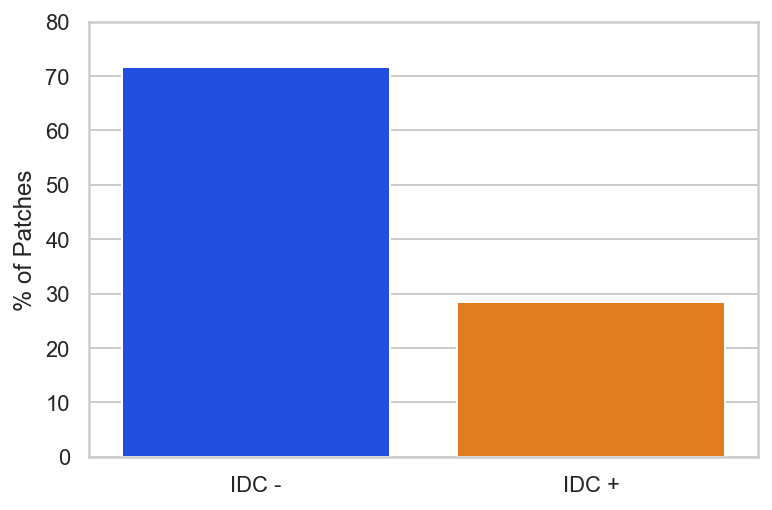

In [11]:
df_target_pc = df_data['target'].value_counts() / len(df_data) * 100
target_names = ['IDC -', 'IDC +']
target_pc = [df_target_pc[0], df_target_pc[1]]
f, ax = plt.subplots()
sns.barplot(x=target_names, y=target_pc, ax=ax)
ax.set_ylabel('% of Patches')
ax.set_ylim([0, 80])
f.savefig('images/chapter_05_target_pc.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_target_pc.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [12]:
df_data_pos = df_data[df_data['target'] == 1].reset_index(drop=True)
df_data_neg = df_data[df_data['target'] == 0].reset_index(drop=True)

In [19]:
num_samples = 4
df_data_pos_sample = df_data_pos.sample(n=num_samples, random_state=42).reset_index(drop=True)
df_data_neg_sample = df_data_neg.sample(n=num_samples, random_state=42).reset_index(drop=True)

IDC Positive Patches


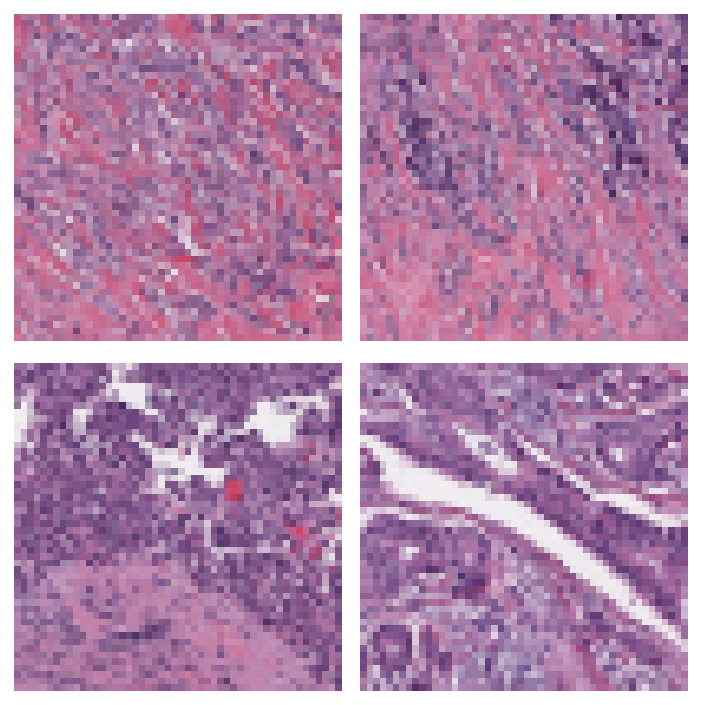

In [20]:
print('IDC Positive Patches')
f, ax = plt.subplots(2, 2, figsize=(5, 5))
axs = np.array(ax)
axs = axs.reshape(num_samples,)
for idx, row in df_data_pos_sample.iterrows():
    image_fname = row['image_id']
    im = cv2.imread(os.path.join(all_images_dir, image_fname))
    im = cv2.resize(im, (50, 50)) 
    axs[idx].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    axs[idx].axis('off')
f.tight_layout()
f.savefig('images/chapter_05_idc_positive_samples.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_idc_positive_samples.pdf', format='pdf', dpi=300, bbox_inches='tight');

IDC Negative Patches


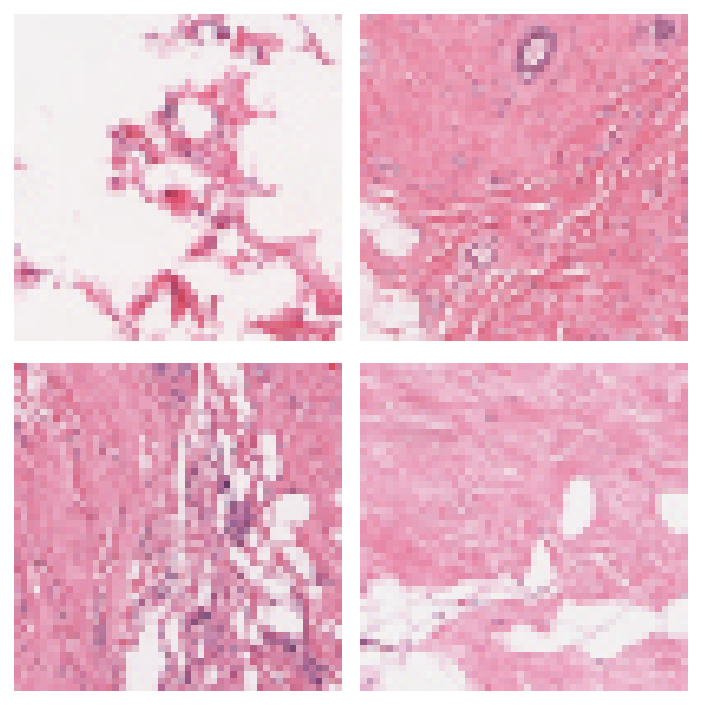

In [21]:
print('IDC Negative Patches')
f, ax = plt.subplots(2, 2, figsize=(5, 5))
axs = np.array(ax)
axs = axs.reshape(num_samples,)
for idx, row in df_data_neg_sample.iterrows():
    image_fname = row['image_id']
    im = cv2.imread(os.path.join(all_images_dir, image_fname))
    im = cv2.resize(im, (50, 50)) 
    axs[idx].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    axs[idx].axis('off')
f.tight_layout()
f.savefig('images/chapter_05_idc_negative_samples.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_idc_negative_samples.pdf', format='pdf', dpi=300, bbox_inches='tight');

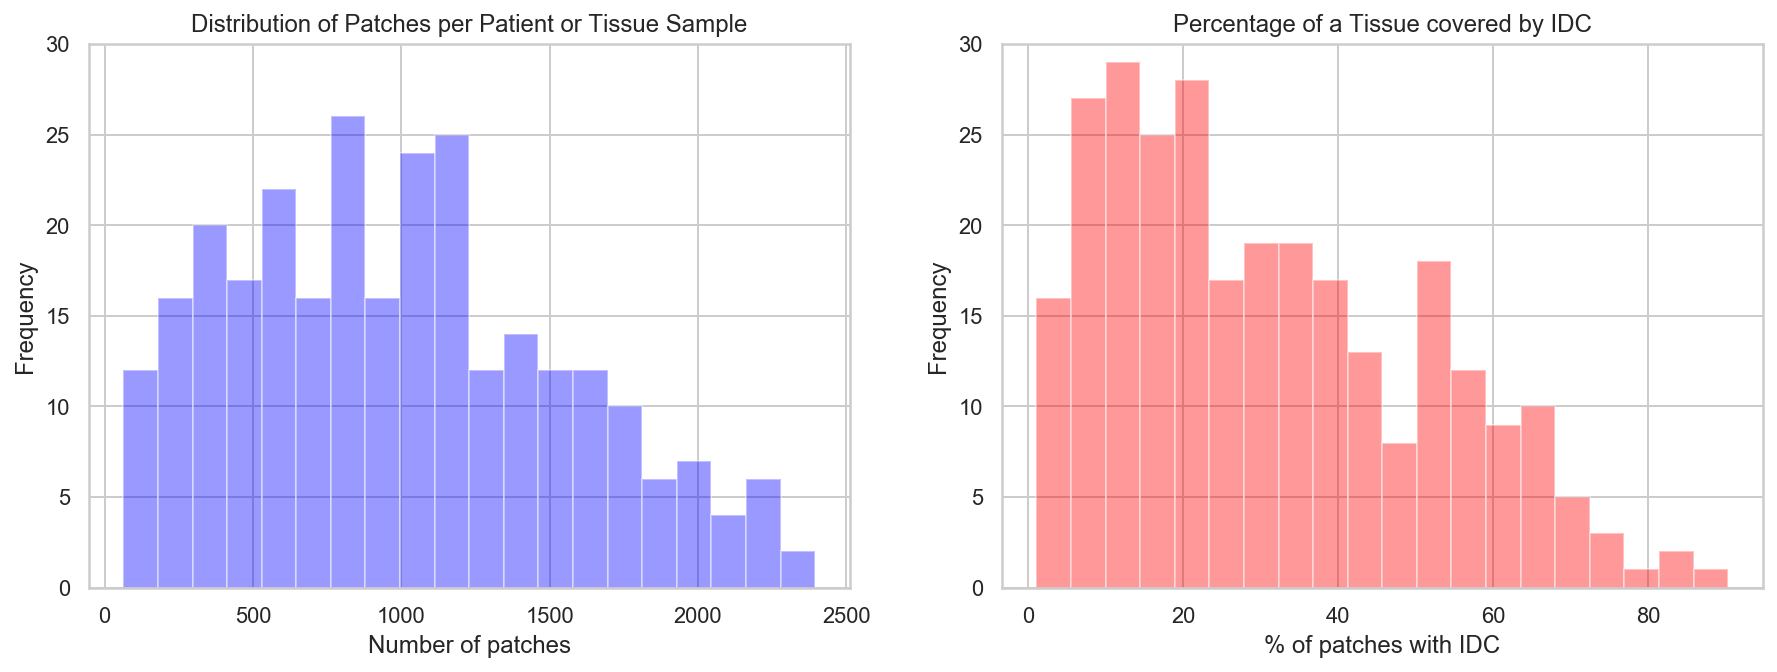

In [19]:
cancer_perc = df_data.groupby("patient_id").target.value_counts() / df_data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()
f, ax = plt.subplots(1, 2,figsize=(15,5))
sns.distplot(df_data.groupby("patient_id").size(), ax=ax[0], color="Blue", kde=False, bins=20)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("Distribution of Patches per Patient or Tissue Sample");
ax[0].set_ylim([0, 30]);
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Red", kde=False, bins=20)
ax[1].set_title("Percentage of a Tissue covered by IDC")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
ax[1].set_ylim([0, 30]);
f.savefig('images/chapter_05_patient_patch_dist.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_patient_patch_dist.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [39]:
cancer_perc.loc[:, 1].max()

0.9035087719298246

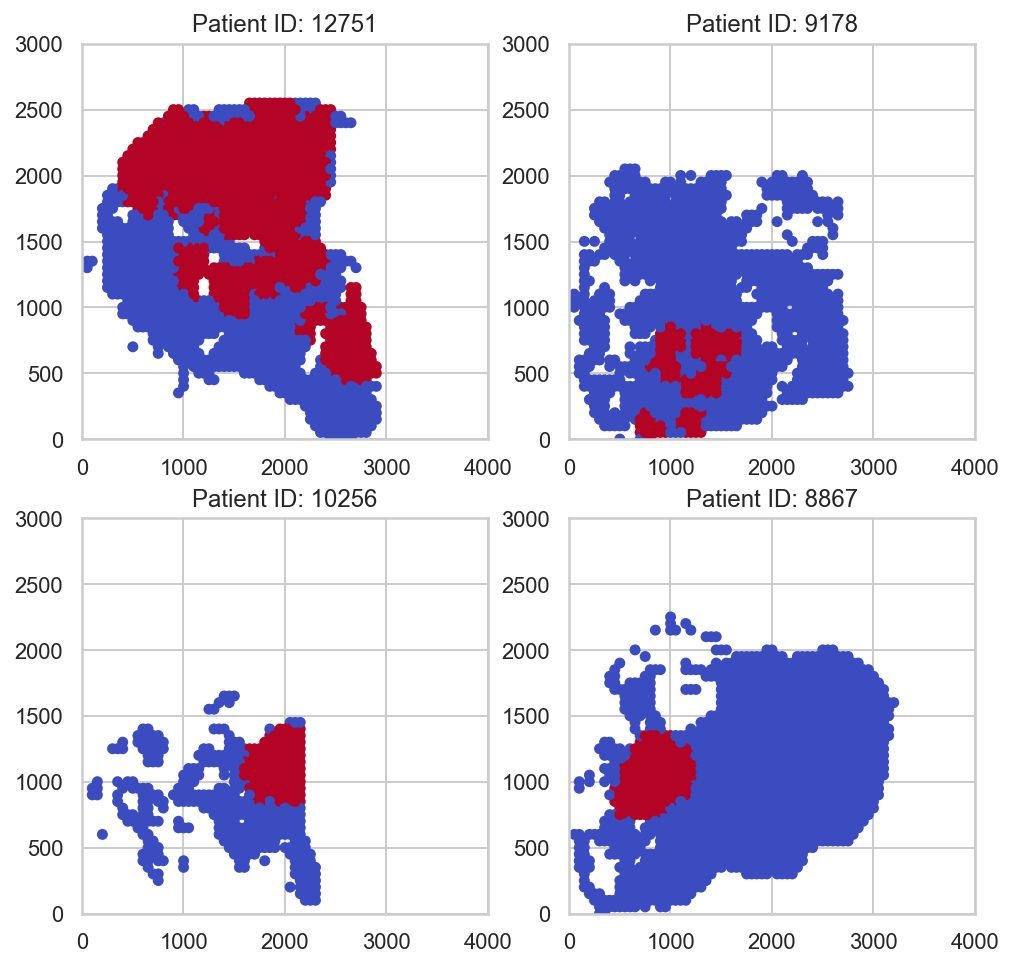

In [20]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
patient_ids = df_data.sample(frac=1, random_state=42).patient_id.unique()
for i in range(2):
    for j in range(2):
        patient_id = patient_ids[j + 3*i]
        df_patient = df_data[df_data['patient_id'] == patient_id].reset_index(drop=True)
        
        ax[i, j].scatter(df_patient.x.values, 
                         df_patient.y.values, 
                         c=df_patient.target.values, 
                         cmap="coolwarm", 
                         s=20);
        ax[i, j].set_title("Patient ID: " + patient_id)
        ax[i, j].set_xlabel("")
        ax[i, j].set_ylabel("")
        ax[i, j].set_xlim([0, 4000])
        ax[i, j].set_ylim([0, 3000])
f.savefig('images/chapter_05_patient_tissue_slice.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_patient_tissue_slice.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [21]:
def extract_breast_tissue_patches(df_data, patient_id):
    df_patient = df_data[df_data['patient_id'] == patient_id].reset_index(drop=True)
    max_point = [df_patient.y.max()-1, df_patient.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    
    broken_patches = []
    for _, row in tqdm(df_patient.iterrows()):
        try:
            image_id = row['image_id']
            target = row['target']
            x_coord = np.int(row['x'])
            y_coord = np.int(row['y'])
            
            image = imread(os.path.join(all_images_dir, image_id))
            
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50
            
            grid[y_start:y_end, x_start:x_end] = image
            
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
        except:
            broken_patches.append(row['image_id'])
    
    return grid, mask, broken_patches

1816it [00:03, 602.24it/s]


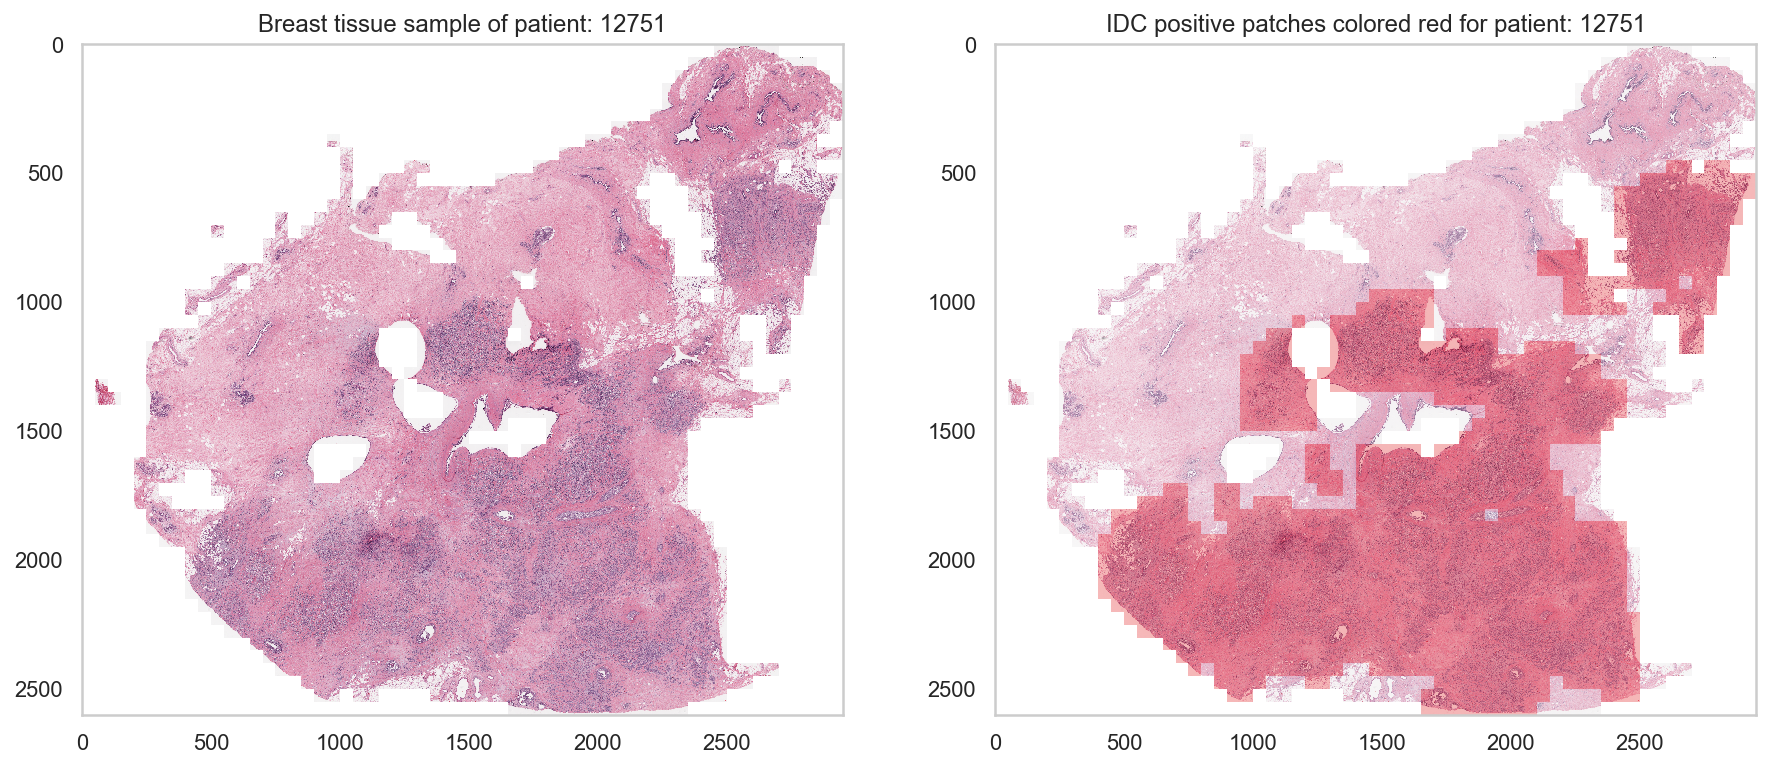

In [22]:
patient_id1 = patient_ids[0]
grid, mask, broken_patches = extract_breast_tissue_patches(df_data, patient_id1)

f, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(grid, alpha=1.0)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
ax[0].set_title("Breast tissue sample of patient: " + patient_id1)
ax[1].set_title("IDC positive patches colored red for patient: " + patient_id1);
f.savefig('images/chapter_05_patient1_breast_tissue.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_patient1_breast_tissue.pdf', format='pdf', dpi=300, bbox_inches='tight');

443it [00:00, 491.41it/s]


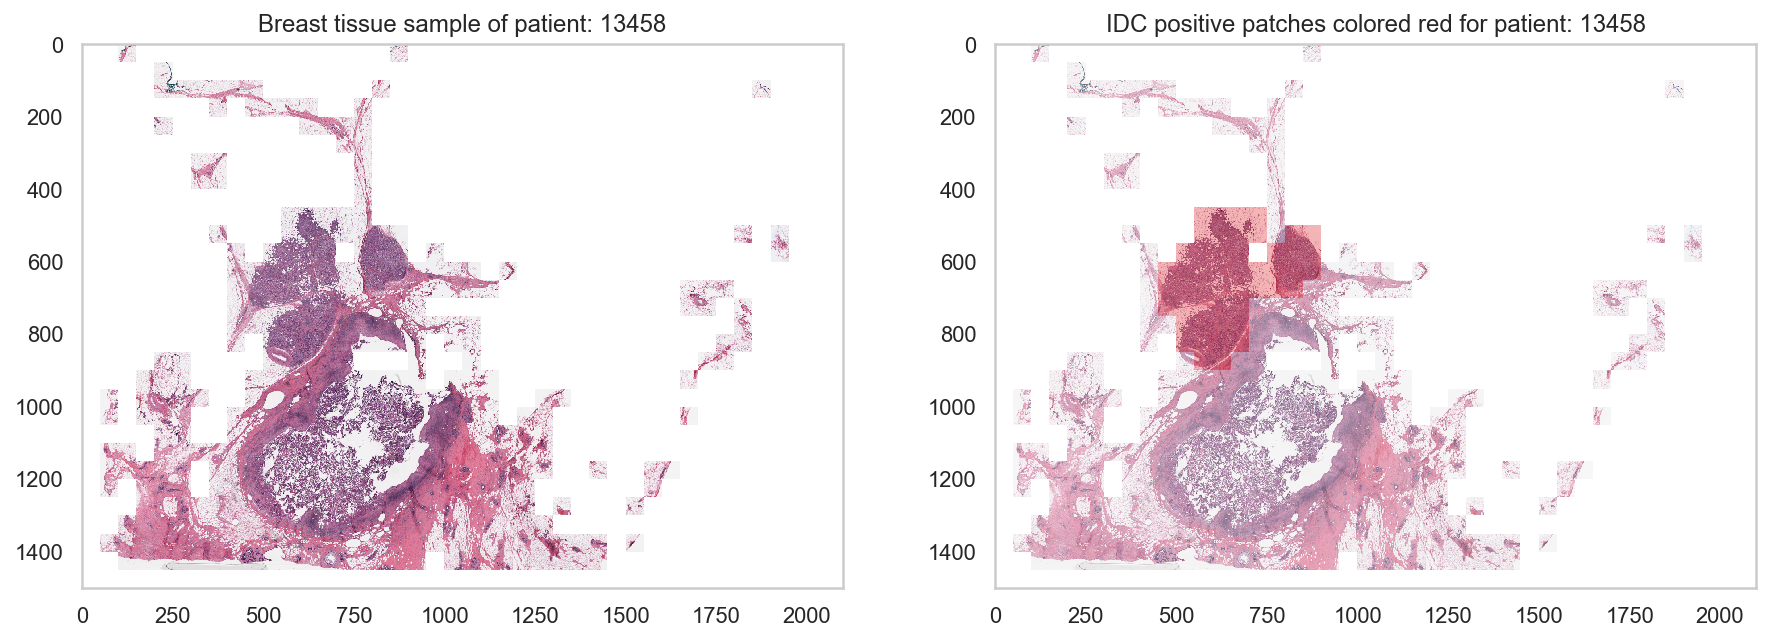

In [23]:
patient_id2 = patient_ids[12]
grid, mask, broken_patches = extract_breast_tissue_patches(df_data, patient_id2)

f, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(grid, alpha=1.0)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
ax[0].set_title("Breast tissue sample of patient: " + patient_id2)
ax[1].set_title("IDC positive patches colored red for patient: " + patient_id2);
f.savefig('images/chapter_05_patient2_breast_tissue.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_patient2_breast_tissue.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [24]:
df_data.to_csv('data/chapter_05_idc.csv', index=False)

# Prepare Data for Training

In [64]:
df_data = pd.read_csv('data/chapter_05_idc.csv')

In [65]:
patient_ids = df_data.patient_id.unique()
train_ids, val_test_ids = train_test_split(patient_ids,
                                           test_size=0.4,
                                           random_state=24)
val_ids, test_ids = train_test_split(val_test_ids, 
                                     test_size=0.5, 
                                     random_state=24)

In [66]:
print('%% of patients in training set: %.1f%%' % (len(train_ids) / len(patient_ids) * 100))
print('%% of patients in validation set: %.1f%%' % (len(val_ids) / len(patient_ids) * 100))
print('%% of patients in test set: %.1f%%' % (len(test_ids) / len(patient_ids) * 100))

% of patients in training set: 59.9%
% of patients in validation set: 20.1%
% of patients in test set: 20.1%


In [67]:
print('Number of patients in training set: %d' % (len(train_ids)))
print('Number of patients in validation set: %d' % (len(val_ids)))
print('Number of patients in test set: %d' % (len(test_ids)))

Number of patients in training set: 167
Number of patients in validation set: 56
Number of patients in test set: 56


In [68]:
df_train = df_data[df_data['patient_id'].isin(train_ids)].reset_index(drop=True)
df_val = df_data[df_data['patient_id'].isin(val_ids)].reset_index(drop=True)
df_test = df_data[df_data['patient_id'].isin(test_ids)].reset_index(drop=True)

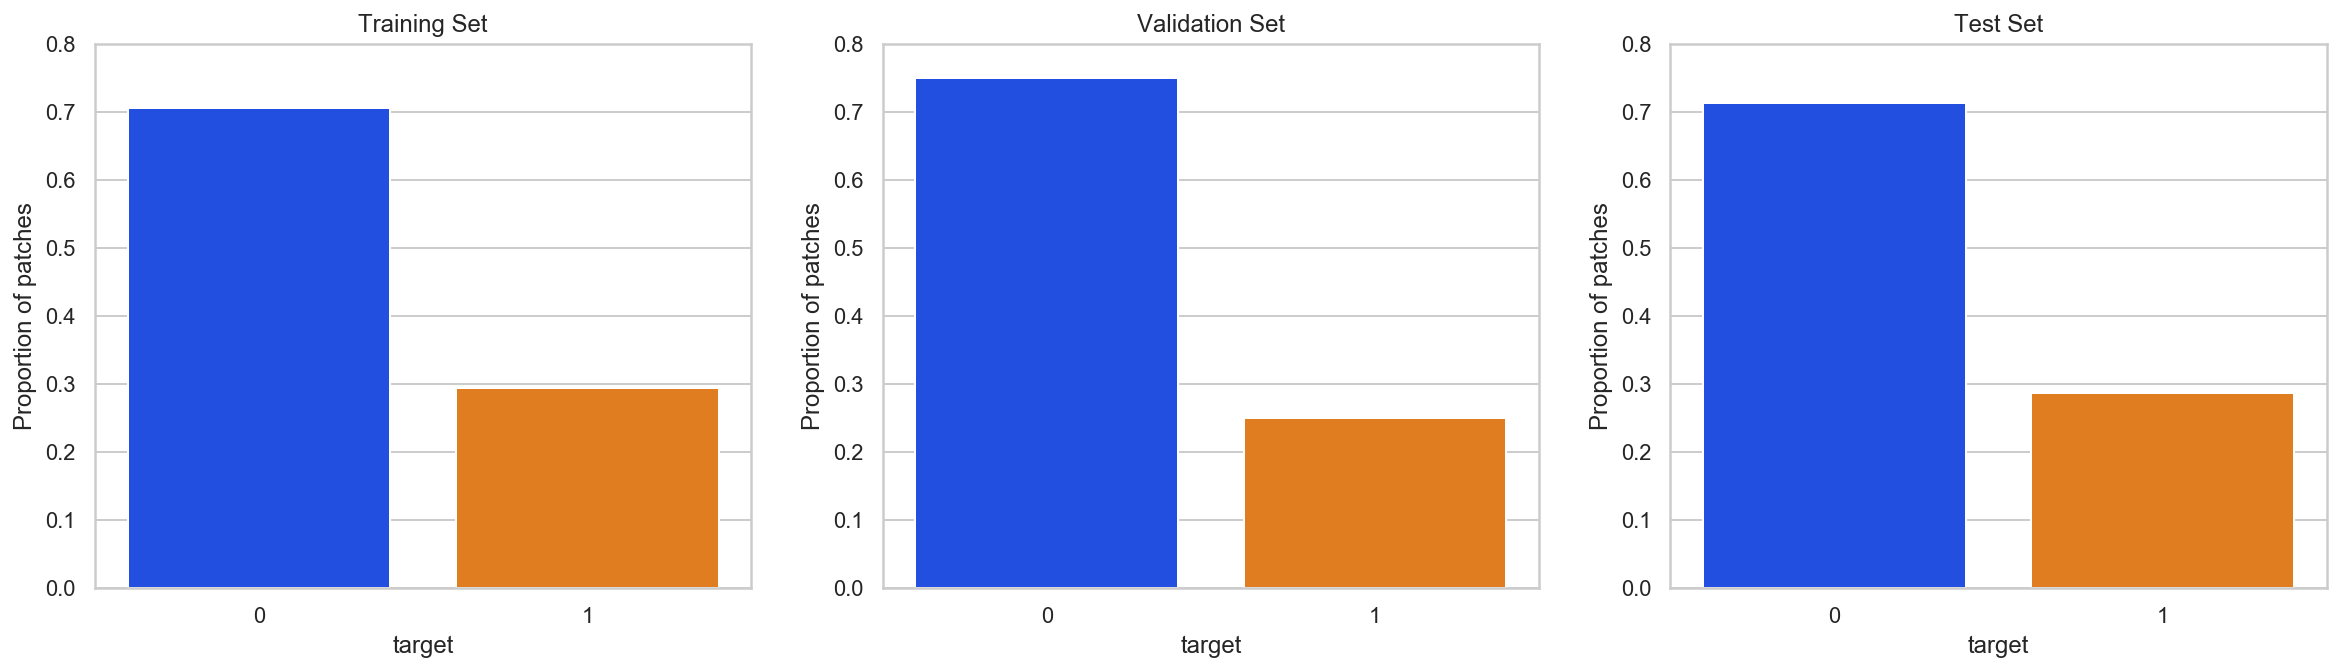

In [11]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))
df_train['target'].\
    value_counts(normalize=True).\
    rename('pc').reset_index().\
    rename(columns={'index': 'target'}).\
    pipe((sns.barplot, "data"), x='target', y='pc', ax=ax[0])
df_val['target'].\
    value_counts(normalize=True).\
    rename('pc').reset_index().\
    rename(columns={'index': 'target'}).\
    pipe((sns.barplot, "data"), x='target', y='pc', ax=ax[1])
df_test['target'].\
    value_counts(normalize=True).\
    rename('pc').reset_index().\
    rename(columns={'index': 'target'}).\
    pipe((sns.barplot, "data"), x='target', y='pc', ax=ax[2])
ax[0].set_ylabel('Proportion of patches')
ax[1].set_ylabel('Proportion of patches')
ax[2].set_ylabel('Proportion of patches')
ax[0].set_ylim([0, 0.8])
ax[1].set_ylim([0, 0.8])
ax[2].set_ylim([0, 0.8])
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
ax[2].set_title('Test Set');
f.savefig('images/chapter_05_train_val_test_splits.png', dpi=300, bbox_inches='tight')
f.savefig('images/chapter_05_train_val_test_splits.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Create Pytorch Dataset

In [69]:
class PatchDataset(Dataset):
    def __init__(self, df_data, images_dir, transform=None):
        super().__init__()
        self.data = list(df_data.itertuples(name='Patch', index=False))
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_id, label = self.data[index].image_id, self.data[index].target
        image = Image.open(os.path.join(self.images_dir, image_id))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [70]:
trans_train = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])])

trans_val = transforms.Compose([transforms.Resize((50, 50)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                     std=[0.5, 0.5, 0.5])])

In [71]:
batch_size = 64
dataset_train = PatchDataset(df_data=df_train, 
                             images_dir=all_images_dir, 
                             transform=trans_train)
dataset_val = PatchDataset(df_data=df_val,
                           images_dir=all_images_dir,
                           transform=trans_val)
dataset_test = PatchDataset(df_data=df_test,
                            images_dir=all_images_dir,
                            transform=trans_val)
loader_train = DataLoader(dataset=dataset_train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
loader_val = DataLoader(dataset=dataset_val, 
                          batch_size=batch_size//2, 
                          shuffle=False, 
                          num_workers=0)
loader_test = DataLoader(dataset=dataset_test, 
                         batch_size=batch_size//2, 
                         shuffle=False, 
                         num_workers=0)

In [72]:
dataloaders = {'train': loader_train,
               'val': loader_val,
               'test': loader_test}
dataset_sizes = {'train': len(df_train),
                 'val': len(df_val),
                 'test': len(df_test)}

# Pytorch CNN - Resnet 18 Architecture

In [74]:
# Hyper parameters
num_epochs = 5
num_classes = 2
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
# Use the ResNet architecture for the CNN
model = torchvision.models.resnet18(pretrained=False)

In [20]:
num_features = model.fc.in_features
print(num_features)

512


In [21]:
# Create the fully connected layers for classification
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, num_classes))

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

In [23]:
weights = compute_class_weight(y=df_train.target.values, 
                               class_weight="balanced", 
                               classes=df_train.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.7081, 1.7016])


In [24]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [25]:
since = time.time()
phases = ['train', 'val', 'test']
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
    
loss_dict = {"train": [], "val": [], "test": []}
lam = 0.0
lam_tensor = torch.tensor(lam, device=device)
    
running_loss_dict = {"train": [], "val": [], "test": []}

smoothing = 0.2
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for phase in phases:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))
        
        counter = 0
        for idx, (inputs, labels) in enumerate(tk0):
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            counter += 1
            tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                             'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
            running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
        
        epoch_loss = running_loss / dataset_sizes[phase]
        loss_dict[phase].append(epoch_loss)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)
results = {"model": model,
           "loss_dict": loss_dict,
           "running_loss_dict": running_loss_dict}

  0%|          | 0/2586 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/1631 [00:00<?, ?it/s]

train Loss: 0.4012 Acc: 0.8321


  0%|          | 0/1871 [00:00<?, ?it/s]

val Loss: 0.4204 Acc: 0.8650


  0%|          | 0/2586 [00:00<?, ?it/s]

test Loss: 0.4205 Acc: 0.8530

Epoch 1/4
----------


  0%|          | 0/1631 [00:00<?, ?it/s]

train Loss: 0.3464 Acc: 0.8499


  0%|          | 0/1871 [00:00<?, ?it/s]

val Loss: 0.3820 Acc: 0.8500


  0%|          | 0/2586 [00:00<?, ?it/s]

test Loss: 0.3614 Acc: 0.8347

Epoch 2/4
----------


  0%|          | 0/1631 [00:00<?, ?it/s]

train Loss: 0.3315 Acc: 0.8579


  0%|          | 0/1871 [00:00<?, ?it/s]

val Loss: 0.3985 Acc: 0.8299


  0%|          | 0/2586 [00:00<?, ?it/s]

test Loss: 0.3807 Acc: 0.8113

Epoch 3/4
----------


  0%|          | 0/1631 [00:00<?, ?it/s]

train Loss: 0.3210 Acc: 0.8623


  0%|          | 0/1871 [00:00<?, ?it/s]

val Loss: 0.4366 Acc: 0.7936


  0%|          | 0/2586 [00:00<?, ?it/s]

test Loss: 0.4330 Acc: 0.7690

Epoch 4/4
----------


  0%|          | 0/1631 [00:00<?, ?it/s]

train Loss: 0.3121 Acc: 0.8661


  0%|          | 0/1871 [00:00<?, ?it/s]

val Loss: 0.3791 Acc: 0.8405


100%|██████████| 1871/1871 [11:24<00:00,  2.73it/s, loss=0.358, accuracy=tensor(0.8296, dtype=torch.float64)]


test Loss: 0.3578 Acc: 0.8296

Training complete in 1007m 24s
Best val Acc: 0.865031


In [54]:
torch.save(model, 'models/chapter_05_idc_resnet18.mdl')

## Evaluate Model

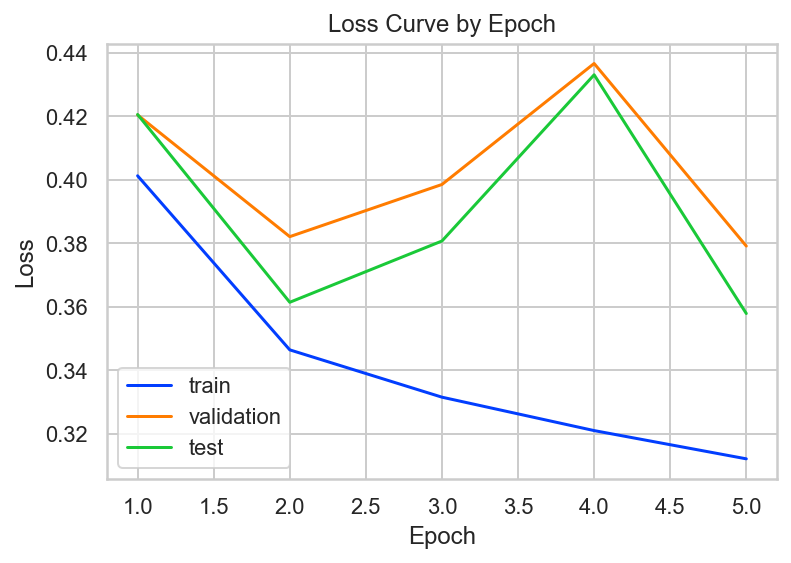

In [53]:
epoch_values = [x+1 for x in range(num_epochs)]
f, ax = plt.subplots()
ax.plot(epoch_values, loss_dict['train'])
ax.plot(epoch_values, loss_dict['val'])
ax.plot(epoch_values, loss_dict['test'])
ax.set_title('Loss Curve by Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['train', 'validation', 'test']);
f.savefig('images/chapter_05_loss_curve_epoch.png', dpi=300, bbox_inches='tight')
f.savefig('images/chapter_05_loss_curve_epoch.pdf', format='pdf', dpi=300, bbox_inches='tight');

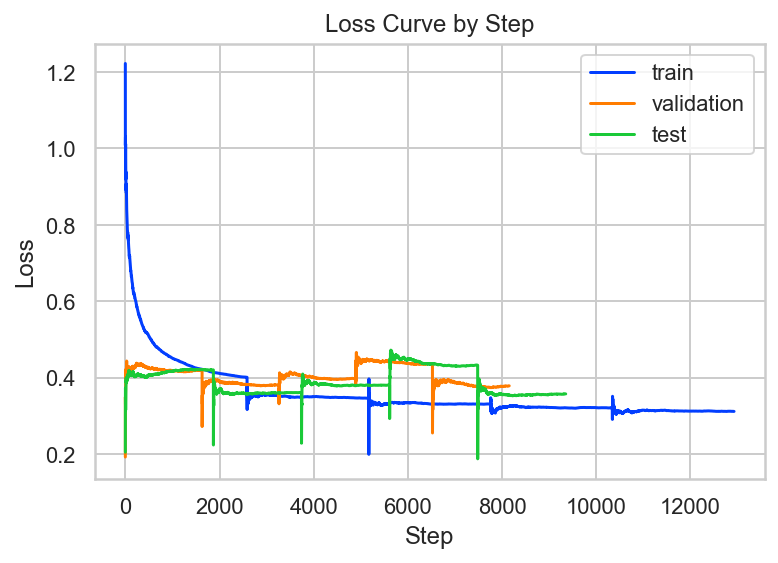

In [52]:
f, ax = plt.subplots()
ax.plot(running_loss_dict['train'])
ax.plot(running_loss_dict['val'])
ax.plot(running_loss_dict['test'])
ax.set_title('Loss Curve by Step')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.legend(['train', 'validation', 'test']);
f.savefig('images/chapter_05_loss_curve_step.png', dpi=300, bbox_inches='tight')
f.savefig('images/chapter_05_loss_curve_step.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [60]:
resnet18_model = torch.load('models/chapter_05_idc_resnet18.mdl')

In [61]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [62]:
def evaluate_model(model, key='test'):
    overall_proba = np.array([])
    overall_preds = np.array([])
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[key])):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            proba = outputs.cpu().numpy().astype(np.float)
            overall_preds = np.append(overall_preds, preds.cpu().numpy().astype(np.int))
            overall_proba = np.append(overall_proba, sigmoid(proba[:, 1]))
    return overall_proba, overall_preds

In [75]:
overall_proba, overall_preds = evaluate_model(resnet18_model)

1871it [12:00,  2.60it/s]


In [76]:
len(df_test)

59867

In [77]:
len(overall_proba)

59867

In [78]:
len(overall_preds)

59867

In [79]:
actual = df_test['target'].values
baseline = np.array([1 for _ in range(len(actual))])

In [58]:
df_test['target'].value_counts()

0    42729
1    17138
Name: target, dtype: int64

In [80]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(actual, overall_preds)
p_baseline = precision_score(actual, baseline)
r_baseline = recall_score(actual, baseline)
recall = recall_score(actual, overall_preds)
f1 = f1_score(actual, overall_preds)
f1_baseline = f1_score(actual, baseline)
print('Precision: ', precision, 'Recall: ', recall, 'F1: ', f1)
print('(Baseline) Precision: ', p_baseline, 'Recall: ', r_baseline, 'F1: ', f1_baseline)

Precision:  0.7443428303435339 Recall:  0.7408682460030342 F1:  0.7426014738565914
(Baseline) Precision:  0.2862678938313261 Recall:  1.0 F1:  0.44511395363937406


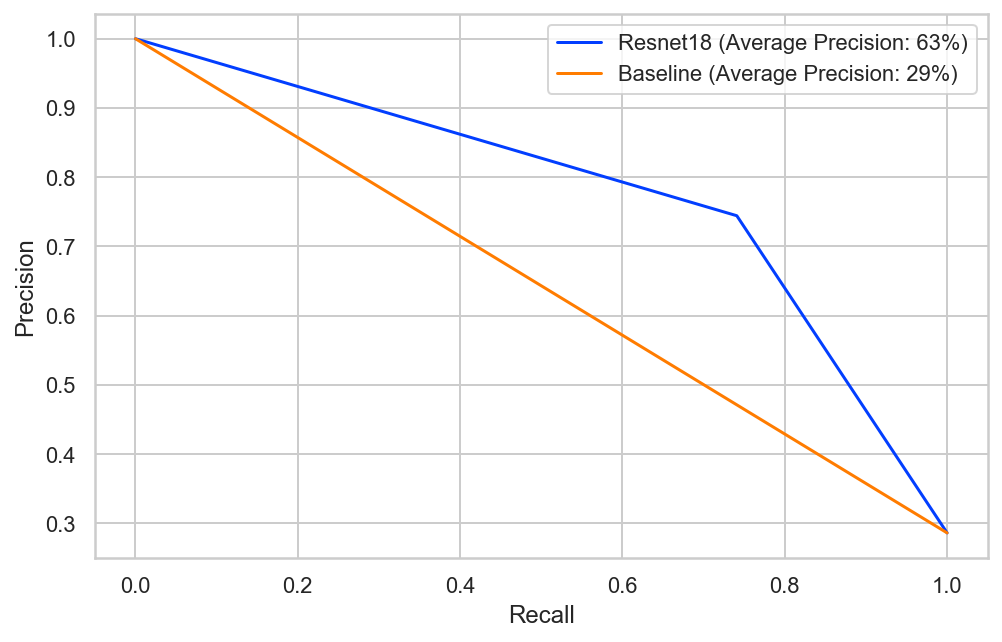

In [93]:
from sklearn.metrics import average_precision_score
pred_p, pred_r, _ = precision_recall_curve(actual, overall_preds)
baseline_p, baseline_r, _ = precision_recall_curve(actual, baseline)
pred_ap = average_precision_score(actual, overall_preds)
baseline_ap = average_precision_score(actual, baseline)
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(pred_r, pred_p, label='Resnet18 (Average Precision: %d%%)' % round(pred_ap * 100))
ax.plot(baseline_r, baseline_p, label='Baseline (Average Precision: %d%%)' % round(baseline_ap * 100))
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');
f.savefig('images/chapter_05_pr_curve.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_pr_curve.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Complexity of Model

In [216]:
resnet18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [215]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(resnet18_model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11572546

# Probabilistic Interpretation

In [81]:
df_test_with_preds = df_test.copy(deep=True)

In [82]:
df_test_with_preds['proba'] = overall_proba
df_test_with_preds['pred'] = overall_preds

In [83]:
df_test_with_preds.to_csv('data/chapter_05_idc_test_preds.csv', index=False)

In [84]:
df_test_with_preds = pd.read_csv('data/chapter_05_idc_test_preds.csv')
df_test_with_preds.head()

image_id  patient_id     x     y  target  \
0    10295_idx5_x801_y951_class0.png       10295   801   951       0   
1  10301_idx5_x1551_y1701_class0.png       10301  1551  1701       0   
2   10301_idx5_x2201_y501_class0.png       10301  2201   501       0   
3    9344_idx5_x1801_y851_class1.png        9344  1801   851       1   
4     9029_idx5_x601_y801_class0.png        9029   601   801       0   

      proba  pred  
0  0.065265   0.0  
1  0.133603   0.0  
2  0.073064   0.0  
3  0.717581   1.0  
4  0.096439   0.0

In [85]:
patient_ids_test = df_test_with_preds['patient_id'].unique()

In [86]:
def extract_breast_tissue_patches_with_preds(df_data, patient_id):
    df_patient = df_data[df_data['patient_id'] == patient_id].reset_index(drop=True)
    max_point = [df_patient.y.max()-1, df_patient.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    df_patient = df_data[df_data.patient_id == patient_id].reset_index(drop=True)
    
    broken_patches = []
    for _, row in tqdm(df_patient.iterrows()):
        try:
            image_id = row['image_id']
            target = row['target']
            x_coord = np.int(row['x'])
            y_coord = np.int(row['y'])
            
            image = imread(os.path.join(all_images_dir, image_id))
            
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50
            
            grid[y_start:y_end, x_start:x_end] = image
            
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            proba = df_patient[(df_patient.x==x_coord) & (df_patient.y==y_coord)].proba
            mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)
        except:
            broken_patches.append(row['image_id'])
    
    return grid, mask, broken_patches, mask_proba

1000it [00:03, 298.30it/s]


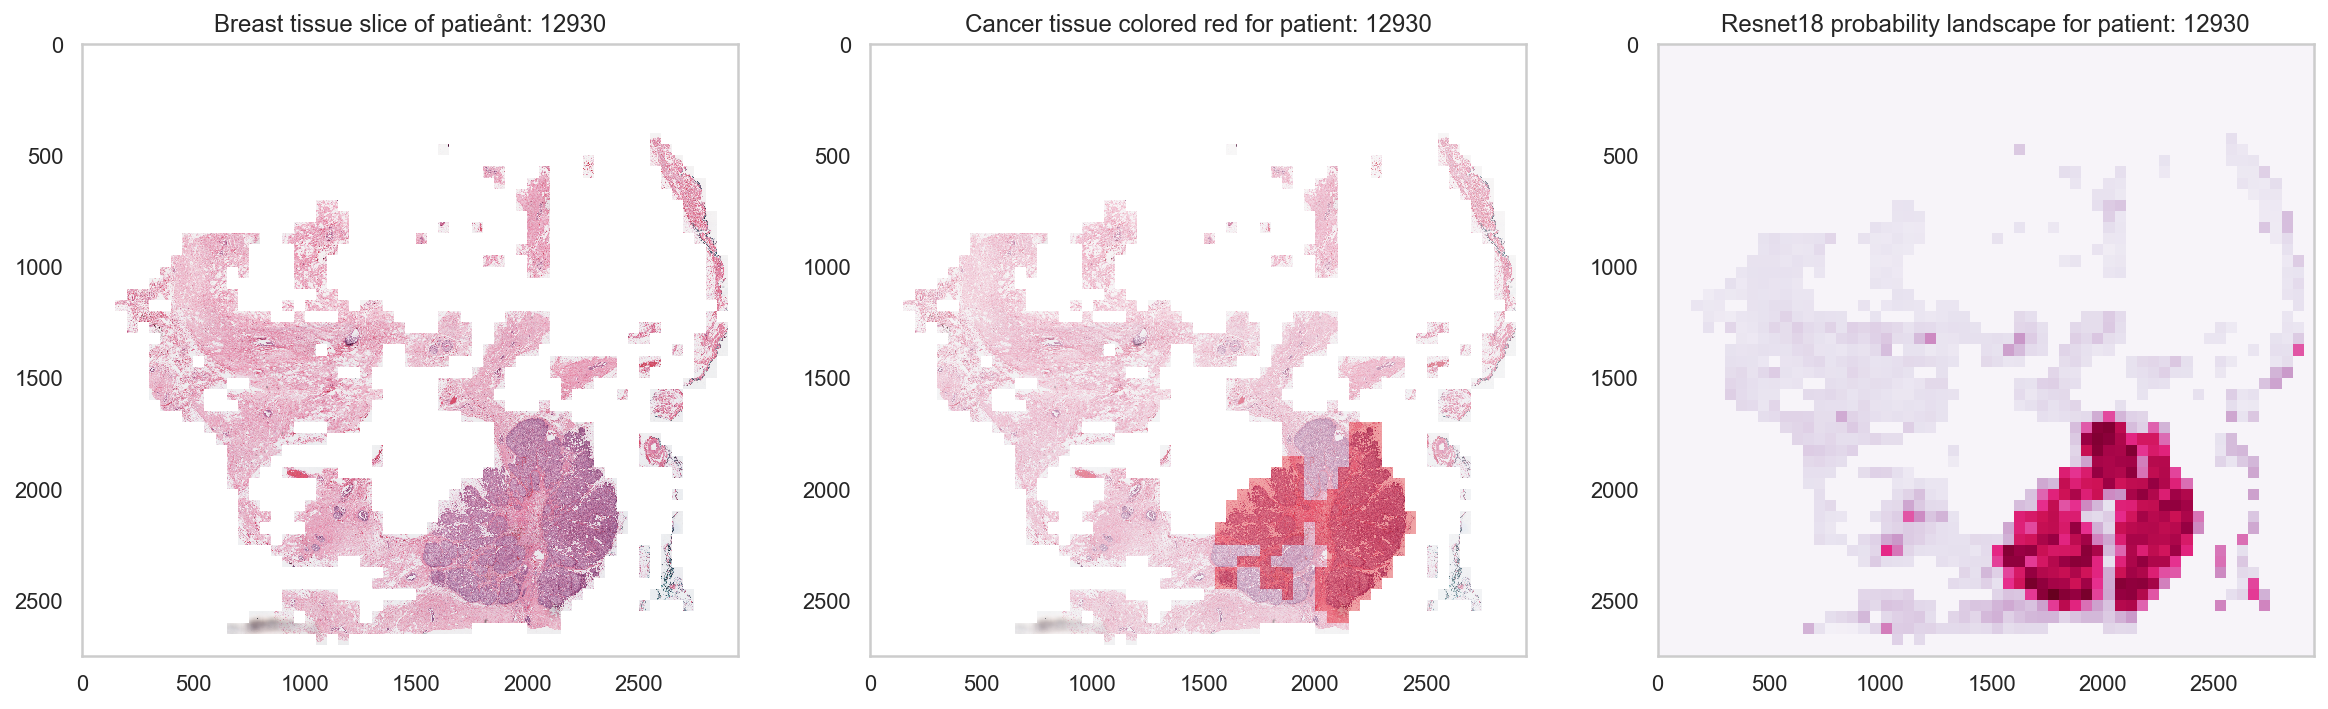

In [92]:
patient_id1 = patient_ids_test[25]
grid, mask, broken_patches, mask_proba = extract_breast_tissue_patches_with_preds(df_test_with_preds, 
                                                                                  patient_id1)

f, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(grid, alpha=1.0)
ax[1].imshow(mask, cmap="Reds")
ax[1].imshow(grid, alpha=0.7)
ax[2].imshow(mask_proba[:,:,0], cmap="PuRd")
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title("Breast tissue slice of patieånt: " + str(patient_id1))
ax[1].set_title("Cancer tissue colored red for patient: " + str(patient_id1))
ax[2].set_title("Resnet18 probability landscape for patient: " + str(patient_id1));
f.savefig('images/chapter_05_patient1_breast_tissue_proba.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_patient1_breast_tissue_proba.pdf', format='pdf', dpi=300, bbox_inches='tight');

1416it [00:06, 210.84it/s]


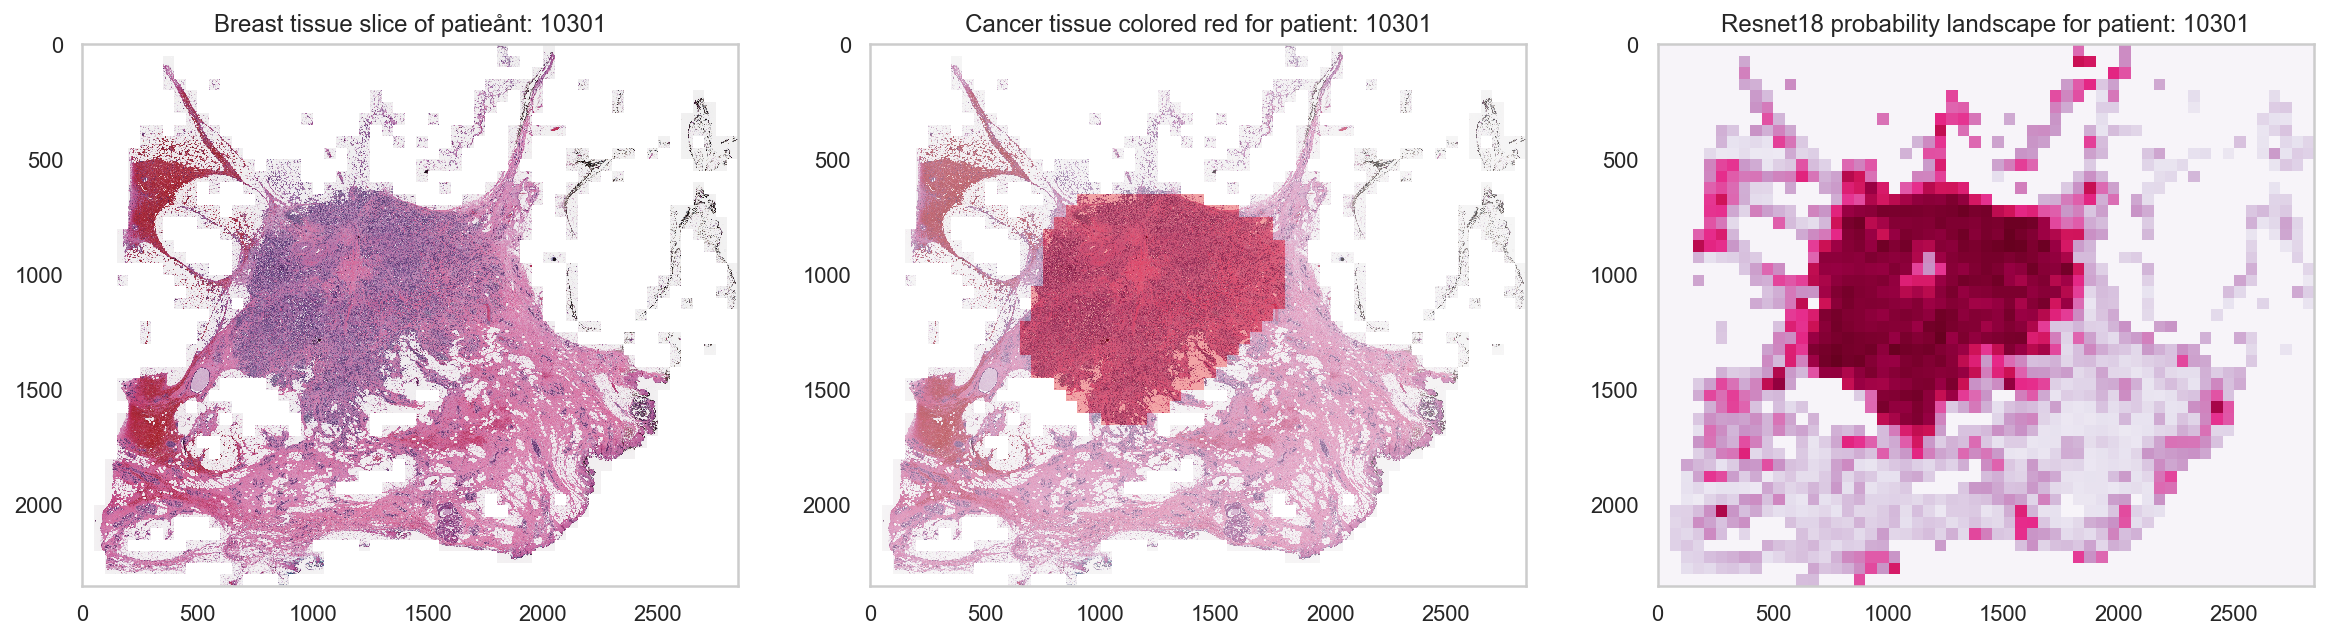

In [96]:
patient_id2 = patient_ids_test[1]
grid, mask, broken_patches, mask_proba = extract_breast_tissue_patches_with_preds(df_test_with_preds, 
                                                                                  patient_id2)

f, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(grid, alpha=1.0)
ax[1].imshow(mask, cmap="Reds")
ax[1].imshow(grid, alpha=0.7)
ax[2].imshow(mask_proba[:,:,0], cmap="PuRd")
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title("Breast tissue slice of patieånt: " + str(patient_id2))
ax[1].set_title("Cancer tissue colored red for patient: " + str(patient_id2))
ax[2].set_title("Resnet18 probability landscape for patient: " + str(patient_id2));
f.savefig('images/chapter_05_patient2_breast_tissue_proba.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_patient2_breast_tissue_proba.pdf', format='pdf', dpi=300, bbox_inches='tight');

# LIME

In [102]:
from lime import lime_image
from functools import partial

In [150]:
trans_pil = transforms.Compose([transforms.Resize((50, 50)),])
trans_pre = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                     std=[0.5, 0.5, 0.5])])

In [151]:
def batch_predict(images, model):
    def sigmoid(x):
        return 1. / (1 + np.exp(-x))
    batch = torch.stack(tuple(trans_pre(i) for i in images), dim=0)
    outputs = model(batch)
    proba = outputs.detach().cpu().numpy().astype(np.float)
    return sigmoid(proba)

In [152]:
batch_predict_with_model = partial(batch_predict, model=resnet18_model)

In [153]:
def get_image(images_dir, image_id):
    image = Image.open(os.path.join(images_dir, image_id))
    image = image.convert('RGB')
    return image

In [154]:
non_idc_idx = 142
idc_idx = 41291
non_idc_image = get_image(all_images_dir, 
                          df_test.iloc[non_idc_idx, :]['image_id'])
idc_image = get_image(all_images_dir, 
                      df_test.iloc[idc_idx, :]['image_id'])

In [155]:
batch_predict_with_model([trans_pil(non_idc_image), trans_pil(idc_image)])

array([[0.73165077, 0.18177181],
       [0.07544133, 0.80487731]])

In [156]:
np.array(trans_pil(non_idc_image)).shape

(50, 50, 3)

In [157]:
explainer = lime_image.LimeImageExplainer()

In [158]:
non_idc_exp = explainer.explain_instance(np.array(trans_pil(non_idc_image)),
                                         batch_predict_with_model,
                                         num_samples=1000)

100% |########################################################################|


In [159]:
from skimage.segmentation import mark_boundaries

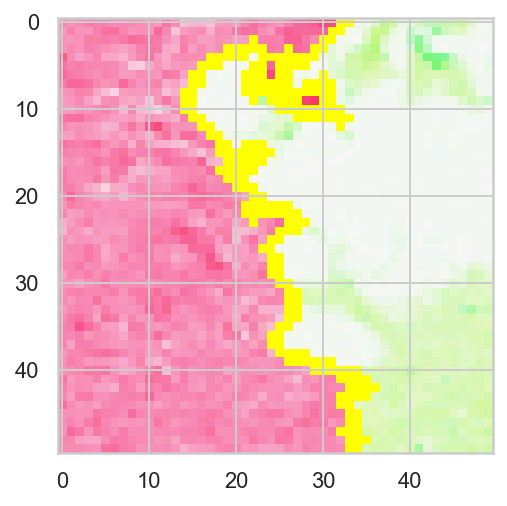

In [189]:
ni_tmp, ni_mask = non_idc_exp.get_image_and_mask(non_idc_exp.top_labels[0], 
                                                 positive_only=False, 
                                                 num_features=20, 
                                                 hide_rest=True)
ni_img_boundary = mark_boundaries(ni_tmp/255.0, ni_mask)
plt.imshow(ni_img_boundary)

In [166]:
idc_exp = explainer.explain_instance(np.array(trans_pil(idc_image)), 
                                     batch_predict_with_model, 
                                     num_samples=1000)

100% |########################################################################|


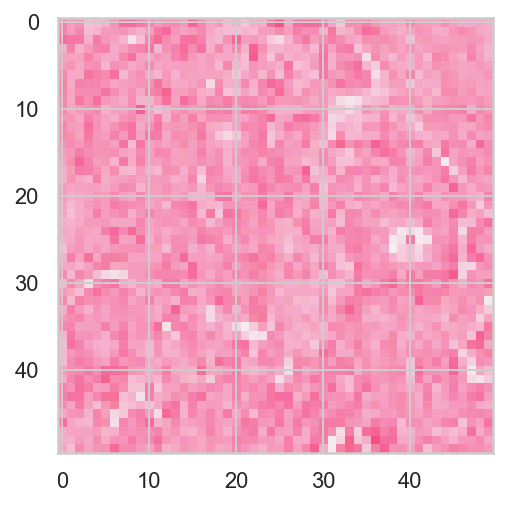

In [190]:
i_tmp, i_mask = idc_exp.get_image_and_mask(idc_exp.top_labels[1], 
                                           positive_only=False, 
                                           num_features=20, 
                                           hide_rest=True)
i_img_boundary = mark_boundaries(i_tmp/255.0, i_mask)
plt.imshow(idc_img_boundary)

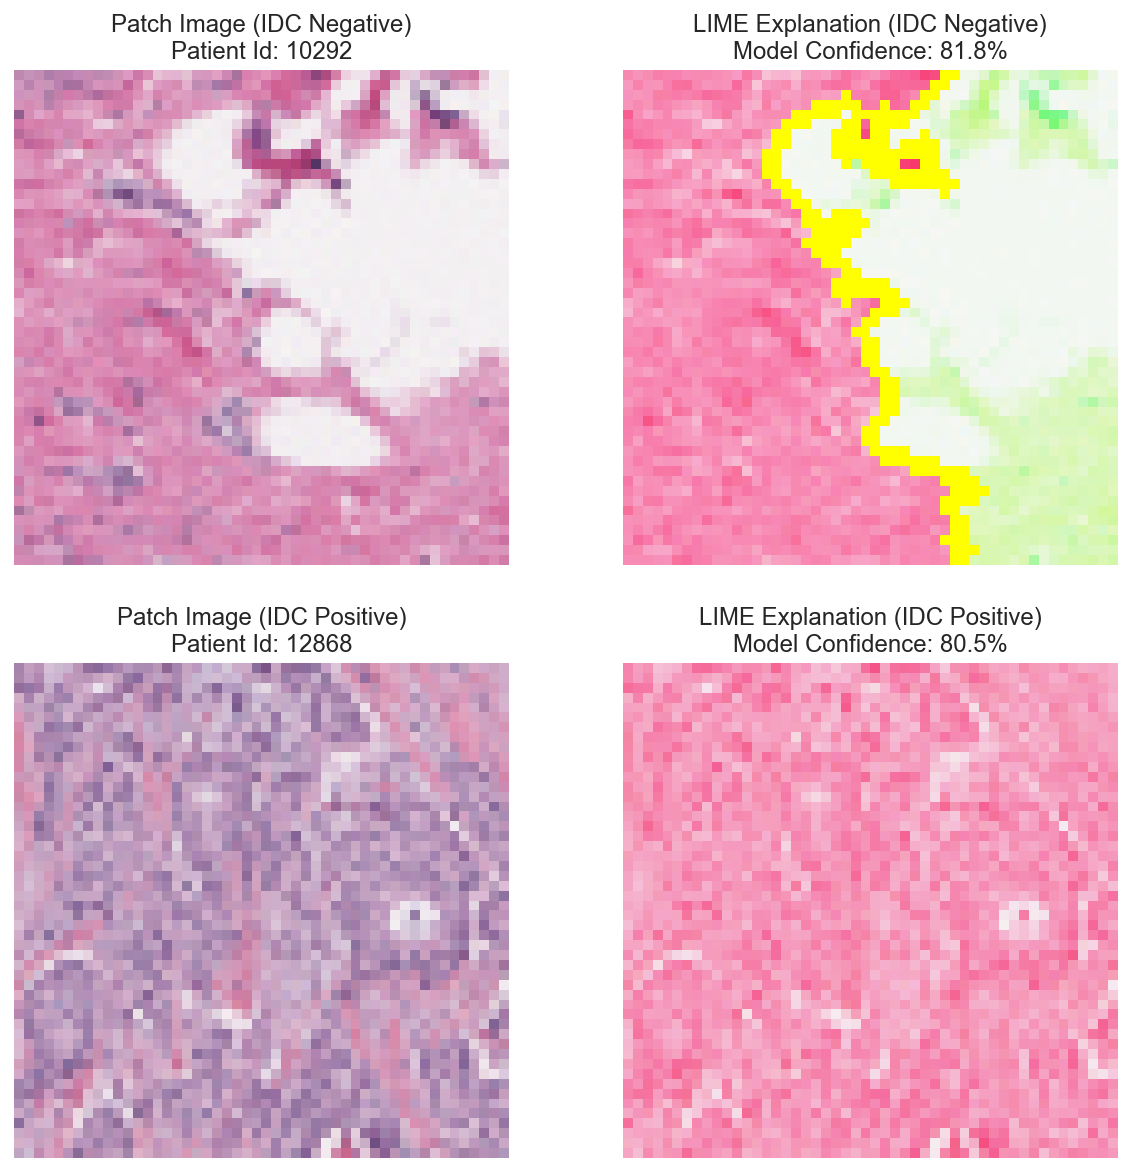

In [193]:
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Patch Image (IDC Negative)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(ni_img_boundary)
ax[0][1].axis('off')
ax[0][1].set_title('LIME Explanation (IDC Negative)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC Positive)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(i_img_boundary)
ax[1][1].axis('off')
ax[1][1].set_title('LIME Explanation (IDC Positive)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_lime_explanation.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_lime_explanation.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Vanilla Backpropagation

Sources:
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/vanilla_backprop.py
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/misc_functions.py

In [275]:
other_model = torchvision.models.resnext50_32x4d(pretrained=False)

In [276]:
other_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [194]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model, features):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Set feature layers
        self.features = features
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.grad_in = grad_in
            self.grad_out = grad_out
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [195]:
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [196]:
def create_gradient_image(gradient):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (D, W, H)
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    return create_image(gradient)

In [197]:
def create_image(im):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    return im

In [198]:
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

In [199]:
non_idc_idx = 142 # 142, 3724 
idc_idx = 41291 # 526, 1472
vbp = VanillaBackprop(model=resnet18_model, 
                      features=resnet18_model)
def get_vanilla_grads(vbp, dataset, idx):
    image, label = dataset[idx]
    print(label)
    X = image.reshape(1, 
                      image.shape[0],
                      image.shape[1],
                      image.shape[2])
    X_var = Variable(X, requires_grad=True)
    vanilla_grads = vbp.generate_gradients(X_var, label)
    return vanilla_grads

non_idc_vanilla_grads = get_vanilla_grads(vbp, dataset_test, non_idc_idx)
idc_vanilla_grads = get_vanilla_grads(vbp, dataset_test, idc_idx)

0
1


In [ ]:
def get_grads(gradient_method, dataset, idx):
    image, label = dataset[idx]
    print(label)
    X = image.reshape(1, 
                      image.shape[0],
                      image.shape[1],
                      image.shape[2])
    X_var = Variable(X, requires_grad=True)
    grads = gradient_method.generate_gradients(X_var, label)
    return grads

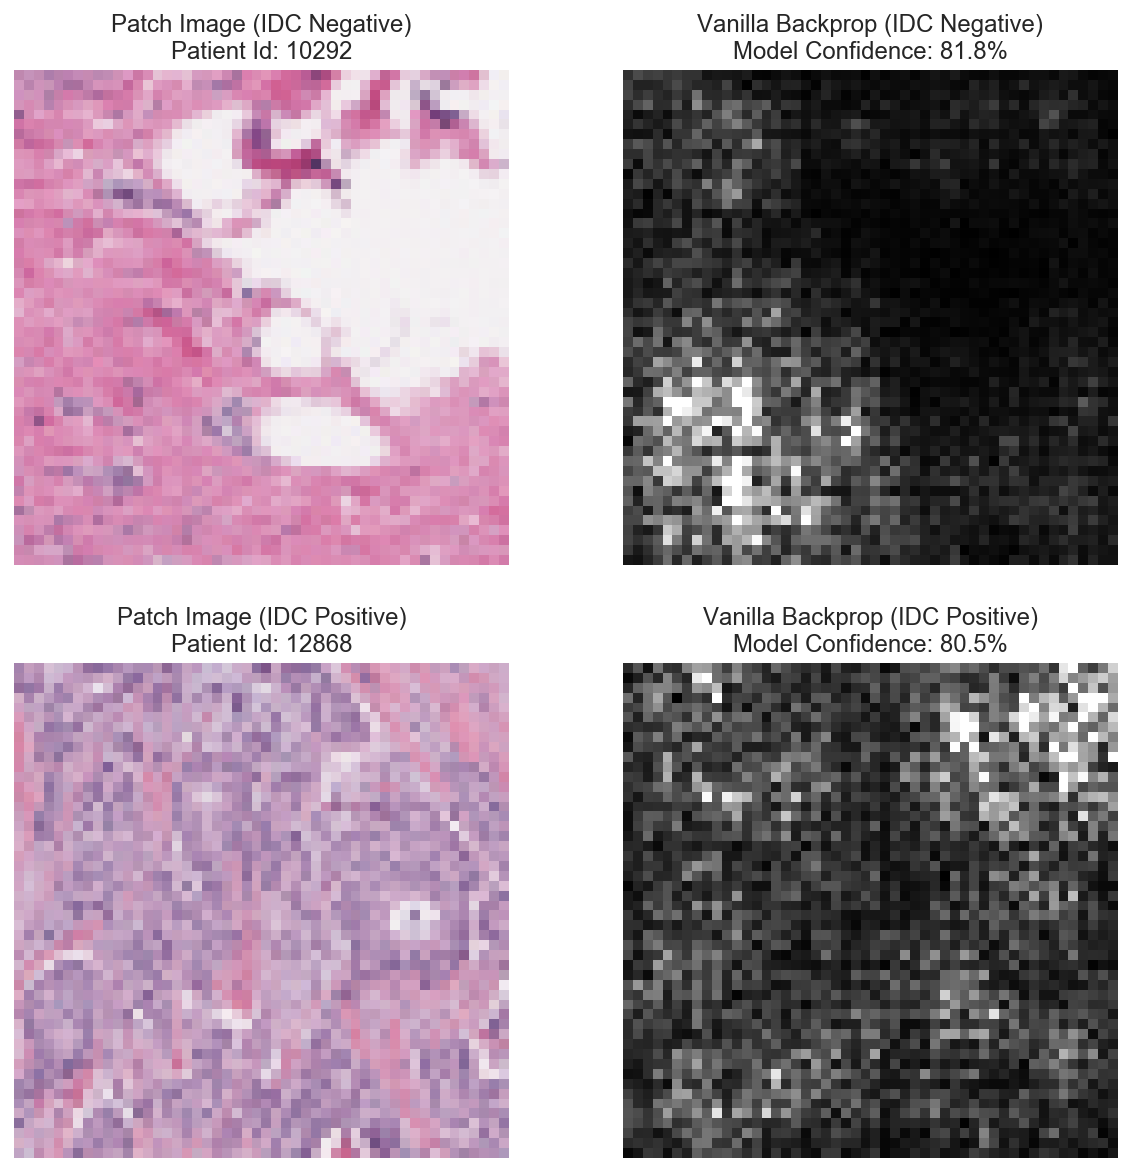

In [200]:
non_idc_vanilla_grad_image = create_gradient_image(convert_to_grayscale(non_idc_vanilla_grads))
idc_vanilla_grad_image = create_gradient_image(convert_to_grayscale(idc_vanilla_grads))
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Patch Image (IDC Negative)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(non_idc_vanilla_grad_image)
ax[0][1].axis('off')
ax[0][1].set_title('Vanilla Backprop (IDC Negative)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC Positive)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(idc_vanilla_grad_image)
ax[1][1].axis('off')
ax[1][1].set_title('Vanilla Backprop (IDC Positive)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_vanilla_backprop.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_vanilla_backprop.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Guided Backpropagation

Sources:
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/guided_backprop.py
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/misc_functions.py

In [201]:
from torch.nn import ReLU, Sequential

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, features):
        self.model = model
        self.gradients = None
        self.features = features
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)
            elif isinstance(module, Sequential):
                for sub_pos, sub_module in module._modules.items():
                    if isinstance(sub_module, ReLU):
                        sub_module.register_backward_hook(relu_backward_hook_function)
                        sub_module.register_forward_hook(relu_forward_hook_function)
                    elif isinstance(sub_module, torchvision.models.resnet.BasicBlock):
                        for subsub_pos, subsub_module in sub_module._modules.items():
                            if isinstance(subsub_module, ReLU):
                                subsub_module.register_backward_hook(relu_backward_hook_function)
                                subsub_module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [202]:
gbp = GuidedBackprop(model=resnet18_model, 
                     features=resnet18_model)
def get_guided_grads(gbp, dataset, idx):
    image, label = dataset[idx]
    print(label)
    X = image.reshape(1, 
                      image.shape[0],
                      image.shape[1],
                      image.shape[2])
    X_var = Variable(X, requires_grad=True)
    guided_grads = gbp.generate_gradients(X_var, label)
    return guided_grads

non_idc_guided_grads = get_guided_grads(gbp, dataset_test, non_idc_idx)
idc_guided_grads = get_guided_grads(gbp, dataset_test, idc_idx)

0
1


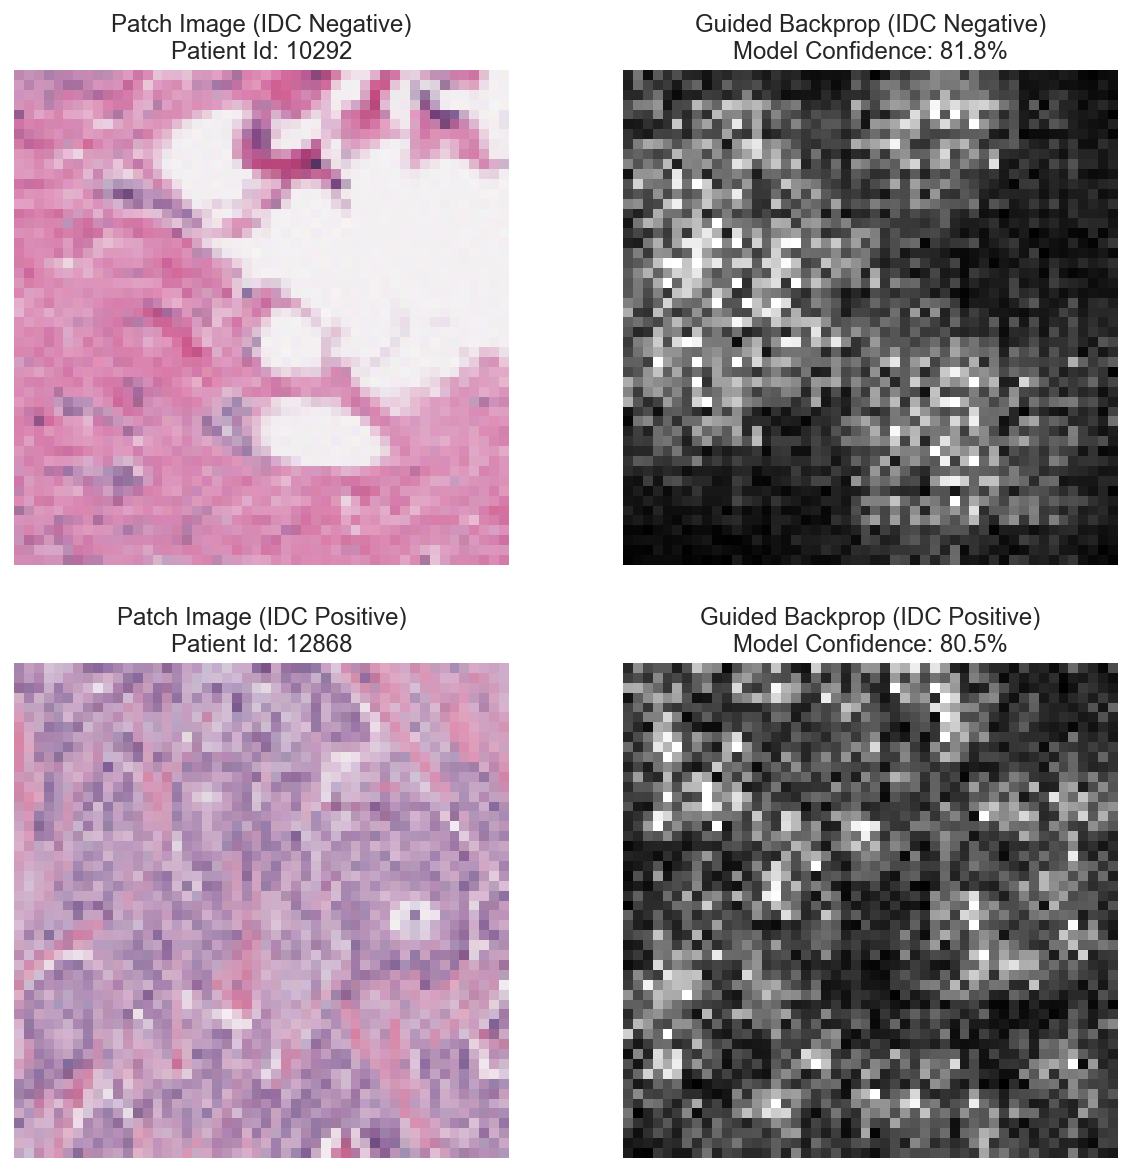

In [203]:
non_idc_guided_grad_image = create_gradient_image(convert_to_grayscale(non_idc_guided_grads))
idc_guided_grad_image = create_gradient_image(convert_to_grayscale(idc_guided_grads))
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Patch Image (IDC Negative)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(non_idc_guided_grad_image)
ax[0][1].axis('off')
ax[0][1].set_title('Guided Backprop (IDC Negative)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC Positive)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(idc_guided_grad_image)
ax[1][1].axis('off')
ax[1][1].set_title('Guided Backprop (IDC Positive)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_guided_backprop.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_guided_backprop.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Integrated Gradients

Sources:
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/integrated_gradients.py
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/misc_functions.py

In [339]:
class IntegratedGradients():
    """
        Produces gradients generated with integrated gradients from the image
    """
    def __init__(self, model, features):
        self.model = model
        self.features = features
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate uniform numbers between 0 and steps
        step_list = np.arange(steps+1)/steps
        # Generate scaled xbar images
        xbar_list = [input_image*step for step in step_list]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,224,224)
        return integrated_grads[0]

In [588]:
ig = IntegratedGradients(resnet18_model, resnet18_model)
def get_integrated_grads(ig, dataset, idx, steps=100):
    image, label = dataset[idx]
    print(label)
    X = image.reshape(1, 
                      image.shape[0],
                      image.shape[1],
                      image.shape[2])
    X_var = Variable(X, requires_grad=True)
    integrated_grads = ig.generate_integrated_gradients(X_var, label, steps)
    return integrated_grads

non_idc_integrated_grads = get_integrated_grads(ig, dataset_test, non_idc_idx)
idc_integrated_grads = get_integrated_grads(ig, dataset_test, idc_idx)

0
1


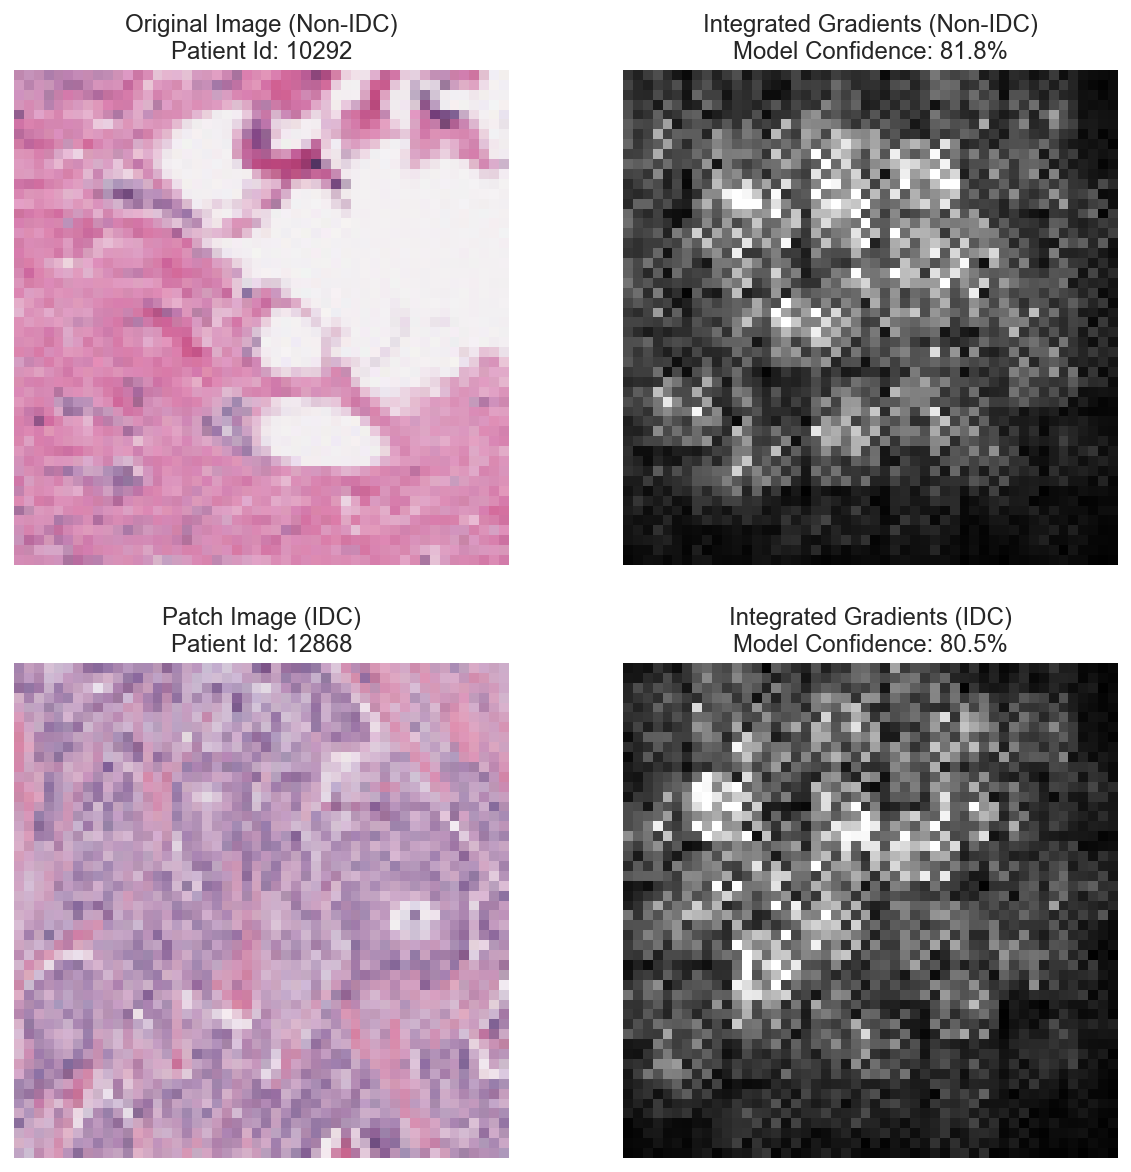

In [589]:
non_idc_integrated_grad_image = create_gradient_image(convert_to_grayscale(non_idc_integrated_grads))
idc_integrated_grad_image = create_gradient_image(convert_to_grayscale(idc_integrated_grads))
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Original Image (Non-IDC)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(non_idc_integrated_grad_image)
ax[0][1].axis('off')
ax[0][1].set_title('Integrated Gradients (Non-IDC)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(idc_integrated_grad_image)
ax[1][1].axis('off')
ax[1][1].set_title('Integrated Gradients (IDC)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_integrated_gradients.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_integrated_gradients.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Grad-CAM

- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/gradcam.py
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/guided_gradcam.py
- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/misc_functions.py

In [204]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, features, fc, fc_layer, target_layer):
        self.model = model
        self.features = features
        self.fc = fc
        self.fc_layer = fc_layer
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.features._modules.items():
            if module_pos == self.fc_layer:
                break
            x = module(x)  # Forward
            if module_pos == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.fc(x)
        return conv_output, x

In [205]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, features, fc, fc_layer, target_layer):
        self.model = model
        self.features = features
        self.fc = fc
        self.fc_layer = fc_layer
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, self.features, self.fc, self.fc_layer, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.features.zero_grad()
        self.fc.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam

In [206]:
grad_cam = GradCam(resnet18_model, 
                   features=resnet18_model, 
                   fc=resnet18_model.fc,
                   fc_layer='fc', 
                   target_layer='layer4')
def get_grad_cam(grad_cam, dataset, idx):
    image, label = dataset[idx]
    print(label)
    X = image.reshape(1, 
                      image.shape[0],
                      image.shape[1],
                      image.shape[2])
    X_var = Variable(X, requires_grad=True)
    cam = grad_cam.generate_cam(X_var, label)
    return cam

non_idc_cam = get_grad_cam(grad_cam, dataset_test, non_idc_idx)
idc_cam = get_grad_cam(grad_cam, dataset_test, idc_idx)

0
1


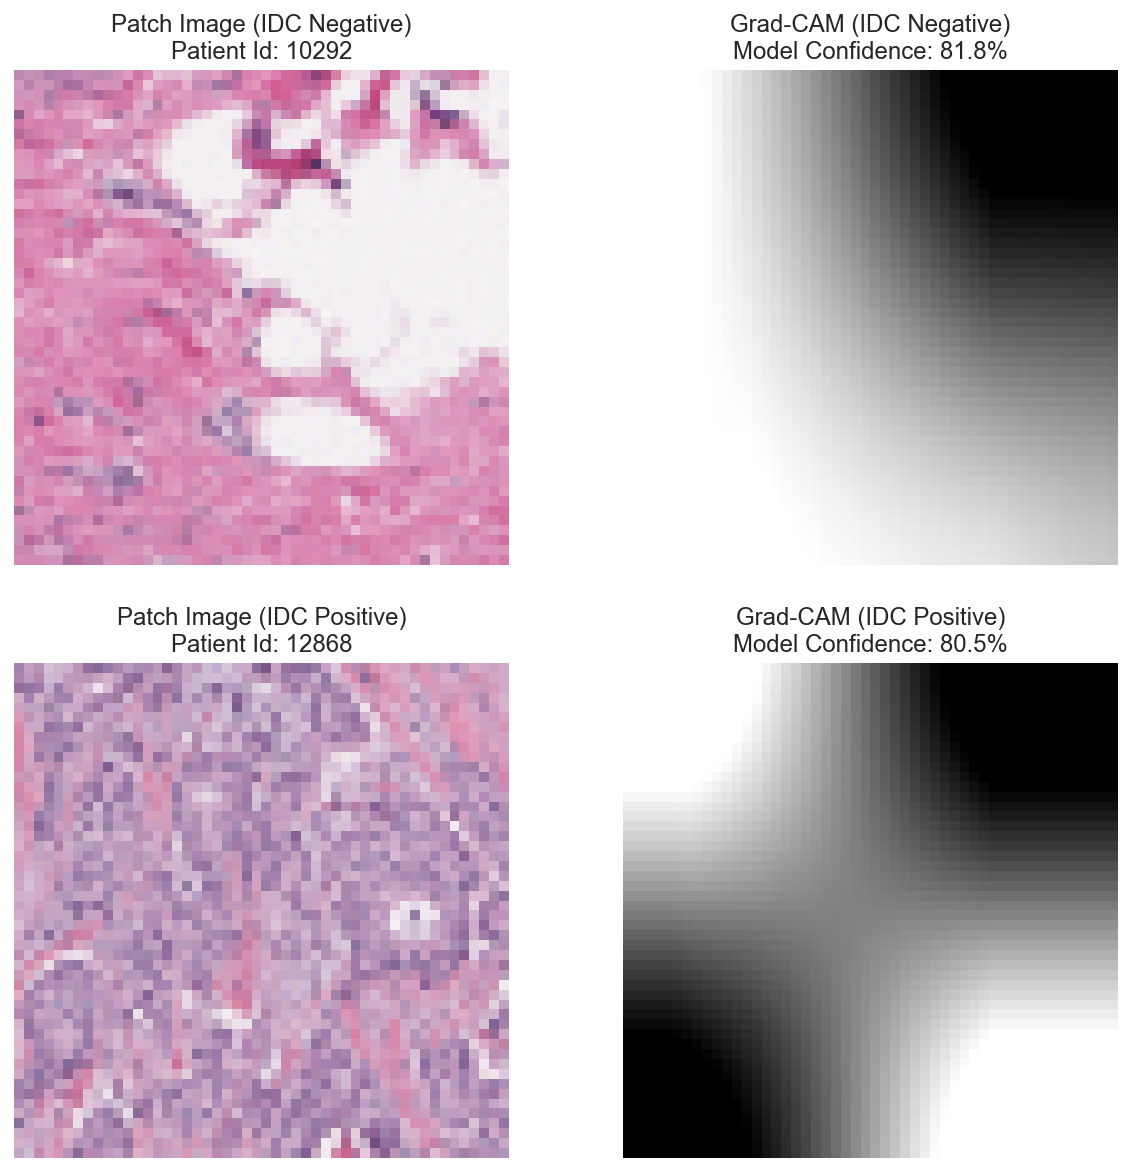

In [207]:
non_idc_cam_image = create_gradient_image(non_idc_cam)
idc_cam_image = create_gradient_image(idc_cam)
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Patch Image (IDC Negative)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(non_idc_cam_image)
ax[0][1].axis('off')
ax[0][1].set_title('Grad-CAM (IDC Negative)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC Positive)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(idc_cam_image)
ax[1][1].axis('off')
ax[1][1].set_title('Grad-CAM (IDC Positive)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_grad_cam.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_grad_cam.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Guided Grad-CAM

In [208]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask
    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

In [209]:
non_idc_guided_cam = guided_grad_cam(non_idc_cam, non_idc_guided_grads)
idc_guided_cam = guided_grad_cam(idc_cam, idc_guided_grads)

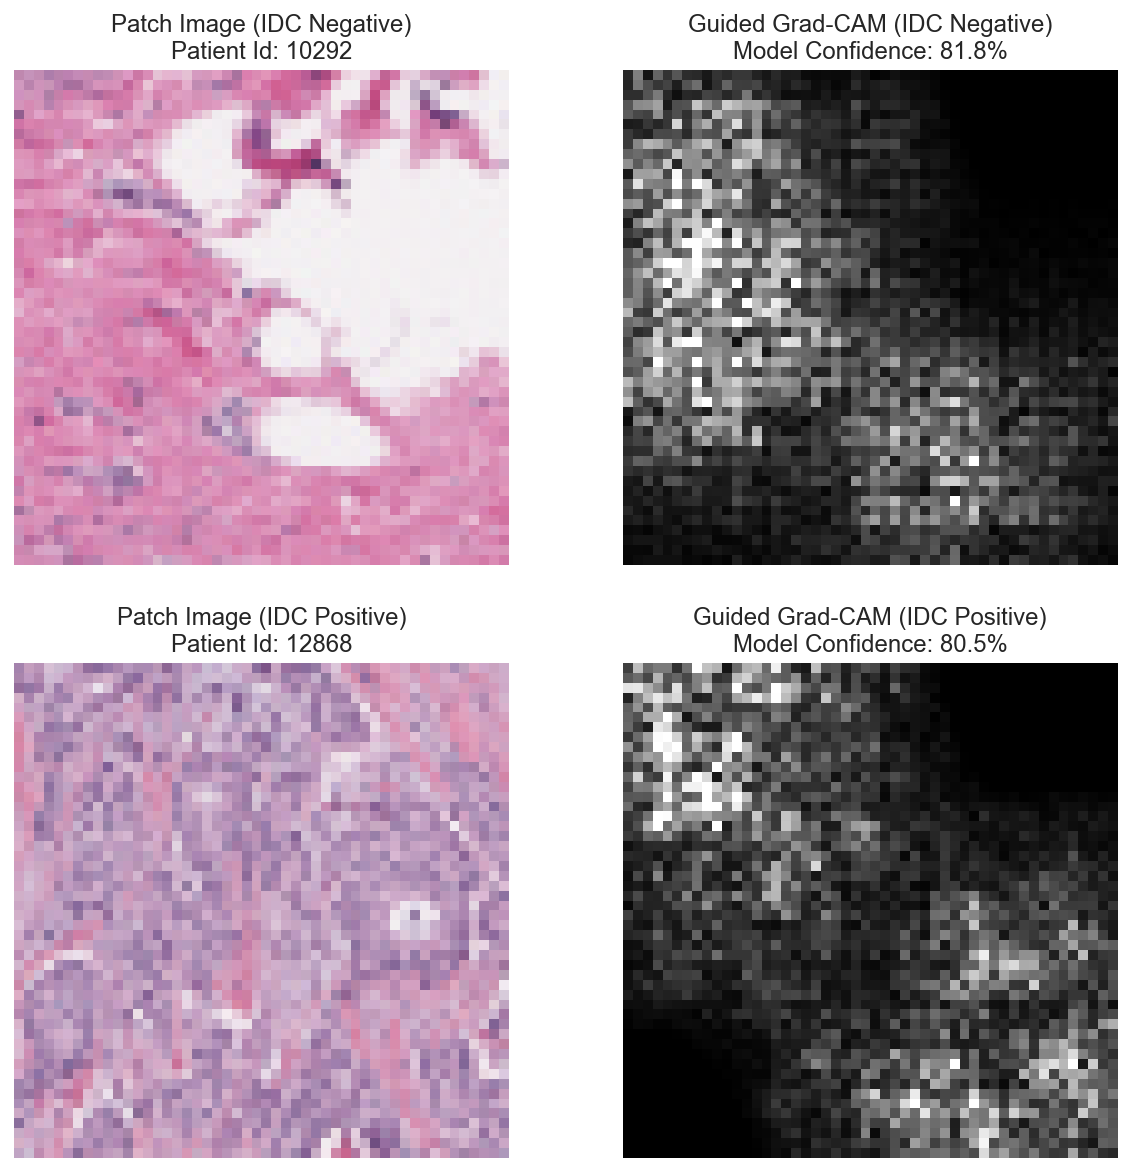

In [210]:
non_idc_guided_cam_image = create_gradient_image(convert_to_grayscale(non_idc_guided_cam))
idc_cam_guided_image = create_gradient_image(convert_to_grayscale(idc_guided_cam))
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Patch Image (IDC Negative)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(non_idc_guided_cam_image)
ax[0][1].axis('off')
ax[0][1].set_title('Guided Grad-CAM (IDC Negative)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC Positive)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(idc_cam_guided_image)
ax[1][1].axis('off')
ax[1][1].set_title('Guided Grad-CAM (IDC Positive)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_guided_grad_cam.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_guided_grad_cam.pdf', format='pdf', dpi=300, bbox_inches='tight');

# SmoothGrad

- https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/smooth_grad.py

In [211]:
def generate_smooth_grad(vbp, prep_img, target_class, param_n, param_sigma_multiplier):
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])
    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    for x in range(param_n):
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = vbp.generate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad

In [212]:
vbp = VanillaBackprop(resnet18_model, resnet18_model)
def get_smooth_grads(vbp, dataset, idx, 
                     param_n=10, 
                     param_sigma_multiplier=0.5):
    image, label = dataset[idx]
    print(label)
    X = image.reshape(1, 
                      image.shape[0],
                      image.shape[1],
                      image.shape[2])
    X_var = Variable(X, requires_grad=True)
    smooth_grads = generate_smooth_grad(vbp, X_var, label, 
                                        param_n,
                                        param_sigma_multiplier)
    return smooth_grads

In [213]:
non_idc_smooth_grads = get_smooth_grads(vbp, dataset_test, non_idc_idx)
idc_smooth_grads = get_smooth_grads(vbp, dataset_test, idc_idx)

0
1


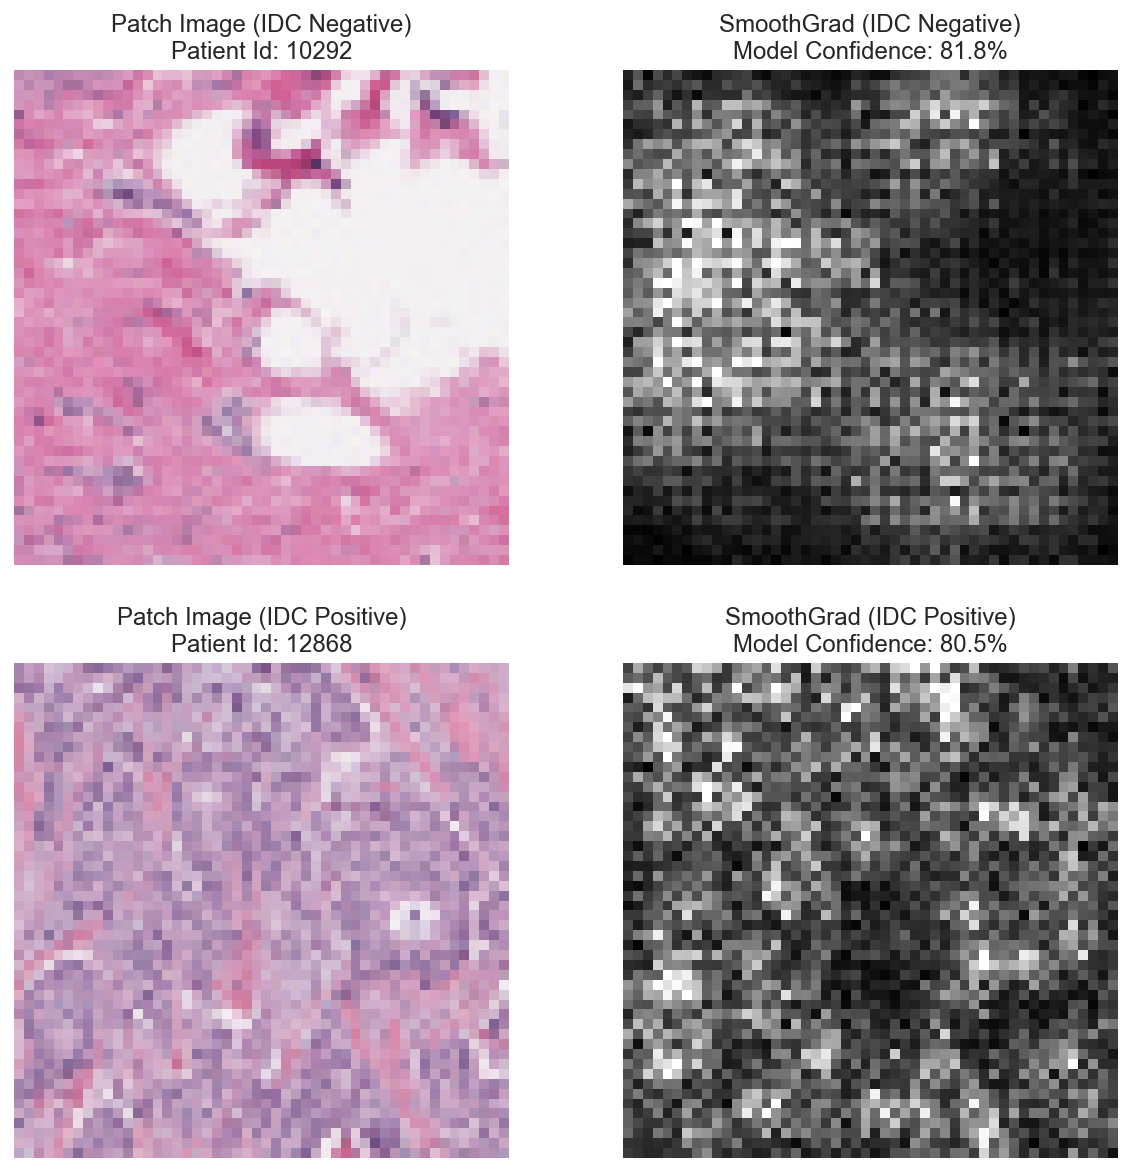

In [214]:
non_idc_smooth_grad_image = create_gradient_image(convert_to_grayscale(non_idc_smooth_grads))
idc_smooth_grad_image = create_gradient_image(convert_to_grayscale(idc_smooth_grads))
non_idc_conf = 100 - df_test_with_preds.iloc[non_idc_idx]['proba'] * 100
idc_conf = df_test_with_preds.iloc[idc_idx]['proba'] * 100
non_idc_image = df_test.iloc[non_idc_idx]['image_id']
idc_image = df_test.iloc[idc_idx]['image_id']
non_idc_patient = df_test.iloc[non_idc_idx]['patient_id']
idc_patient = df_test.iloc[idc_idx]['patient_id']
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, non_idc_image))))
ax[0][0].axis('off')
ax[0][0].set_title('Patch Image (IDC Negative)\nPatient Id: %d' % non_idc_patient)
ax[0][1].imshow(non_idc_smooth_grad_image)
ax[0][1].axis('off')
ax[0][1].set_title('SmoothGrad (IDC Negative)\nModel Confidence: %.1f%%' % non_idc_conf)
ax[1][0].imshow(Image.fromarray(imread(os.path.join(all_images_dir, idc_image))))
ax[1][0].axis('off')
ax[1][0].set_title('Patch Image (IDC Positive)\nPatient Id: %d' % idc_patient)
ax[1][1].imshow(idc_smooth_grad_image)
ax[1][1].axis('off')
ax[1][1].set_title('SmoothGrad (IDC Positive)\nModel Confidence: %.1f%%' % idc_conf);
f.savefig('images/chapter_05_smooth_grad.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_05_smooth_grad.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Layer-wise Relevance Propagation (LRP)

In [257]:
from tqdm.auto import tqdm
import imp 
LRP = imp.load_source('LRP', 'LRP_decomposition/LRP/__init__.py')
from LRP import lrp

In [263]:
lrp_resnet = lrp.LRP(resnet18_model, 'z_rule')

In [264]:
non_idc_idx = 142
idc_idx = 41291
non_idc_image = get_image(all_images_dir, 
                          df_test.iloc[non_idc_idx, :]['image_id'])
idc_image = get_image(all_images_dir, 
                      df_test.iloc[idc_idx, :]['image_id'])

In [265]:
lrp_loader_test = DataLoader(dataset=dataset_test, 
                    batch_size=1, 
                    shuffle=False, 
                    num_workers=0)

In [266]:
lrp_results = {}
for idx, (image, label) in tqdm(enumerate(lrp_loader_test)):
    if idx != non_idc_idx and idx != idc_idx:
        continue
    output = lrp_resnet.forward(image)
    relevance = lrp_resnet(image)
    lrp_results[idx] = {'output': output,
                        'relevance': relevance}

tensor(0.8754)
tensor(1.4937)
tensor(1.9972)
tensor(23.5577)
tensor(28.6491)
tensor(17.0896)
tensor(2.0741)
tensor(47.4654)
tensor(-55.4261)
tensor(2311.1838)
tensor(11480.9141)
tensor(-2253.8184)
tensor(46831.)
tensor(45213.4062)
tensor(1583710.6250)
tensor(1289673.)
tensor(2673237.)
tensor(47290280.)
tensor(-6.3247e+08)
tensor(1.2857e+09)
tensor(3.0353e+09)
tensor(1.1768e+10)
tensor(1.6005e+10)
> /Users/ajay/Workspace/interpretable-ai-book/LRP_decomposition/LRP/rules.py(123)z_box()
    122             import ipdb; ipdb.set_trace() # BREAKPOINT
--> 123             Ri = input * input.grad - L * L.grad - H * H.grad
    124         return Ri

ipdb> c
tensor(1.0741)
tensor(2.1535)
tensor(1.5590)
tensor(3.0467)
tensor(4.9597)
tensor(6.5343)
tensor(2.0166)
tensor(29.3561)
tensor(124.1823)
tensor(519.4215)
tensor(299.3300)
tensor(547.7770)
tensor(1319.8721)
tensor(1928.9668)
tensor(33662.4609)
tensor(77419.1328)
tensor(-90327.9062)
tensor(1023466.6250)
tensor(6353960.)
tensor(44647816.)
tens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


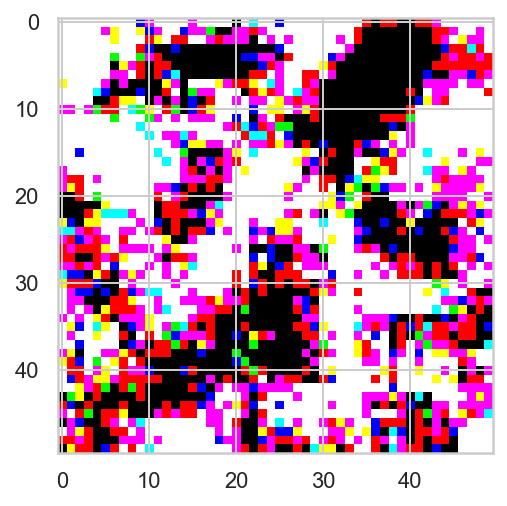

In [268]:
f, ax = plt.subplots()
cmap = plt.cm.get_cmap('seismic')
ax.imshow(np.transpose(lrp_results[idc_idx]['relevance'].squeeze(), [1, 2, 0]))